In [255]:
# Import dependencies
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import wavfile
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks

# Function to apply FFT, find harmonic peaks

In [256]:
def find_harmonics(path, print_peaks=False):
    fs, X = wavfile.read(path)
    N = len(X)
    X_F = fft(X)
    X_F_onesided = 2.0/N * np.abs(X_F[0:N//2])
    freqs = fftfreq(N, 1/fs)[:N//2]
    freqs_50_index = np.abs(freqs - 50).argmin()
    
    h = X_F_onesided.max()*5/100
    peaks, _ = find_peaks(X_F_onesided, distance=10, height = h)
    peaks = peaks[peaks>freqs_50_index]
    harmonics = np.round(freqs[peaks],2)
    
    if print_peaks:
        i = peaks.max() + 100
        plt.plot(freqs[:i], X_F_onesided[:i])
        plt.plot(freqs[peaks], X_F_onesided[peaks], "x")
        plt.xlabel('Frequency [Hz]')
        plt.show()
    return harmonics

# Data Preprocessing and Dataset Import
## Import Data into dataframe

In [257]:
# For macOS be aware of ".DS_Store" file!
path = "./data"
data = []
max_harm_length = 0 # i will keep track of max harmonic length for naming columns

for dirname, _, filenames in os.walk(path):
    print(filenames)
    for filename in filenames:

        # Skip .DS_Store files
        if filename == ".DS_Store":
            continue
        
        foldername = os.path.basename(dirname)
        full_path = os.path.join(dirname, filename)
        freq_peaks = find_harmonics(full_path)
        
        max_harm_length = max(max_harm_length, len(freq_peaks))
        
        cur_data = [foldername, filename]
        cur_data.extend([freq_peaks.min(), freq_peaks.max(), len(freq_peaks)])
        cur_data.extend(freq_peaks)
        
        data.append(cur_data)

[]
['Major_500.wav', 'Major_266.wav', 'Major_272.wav', 'Major_299.wav', 'Major_474.wav', 'Major_312.wav', 'Major_306.wav', 'Major_460.wav', 'Major_448.wav', 'Major_28.wav', 'Major_14.wav', 'Major_110.wav', 'Major_104.wav', 'Major_138.wav', 'Major_139.wav', 'Major_105.wav', 'Major_111.wav', 'Major_15.wav', 'Major_29.wav', 'Major_449.wav', 'Major_307.wav', 'Major_461.wav', 'Major_475.wav', 'Major_313.wav', 'Major_298.wav', 'Major_273.wav', 'Major_501.wav', 'Major_267.wav', 'Major_271.wav', 'Major_265.wav', 'Major_259.wav', 'Major_463.wav', 'Major_305.wav', 'Major_311.wav', 'Major_477.wav', 'Major_339.wav', 'Major_17.wav', 'Major_488.wav', 'Major_107.wav', 'Major_113.wav', 'Major_112.wav', 'Major_106.wav', 'Major_16.wav', 'Major_489.wav', 'Major_338.wav', 'Major_310.wav', 'Major_476.wav', 'Major_462.wav', 'Major_304.wav', 'Major_258.wav', 'Major_264.wav', 'Major_270.wav', 'Major_248.wav', 'Major_274.wav', 'Major_260.wav', 'Major_328.wav', 'Major_300.wav', 'Major_466.wav', 'Major_472.wav',

## Create Harmonic table

In [258]:

# Column Names for DataFrame:
cols = ["Chord Type", "File Name", "Min Harmonic", "Max Harmonic", "# of Harmonics"]
for i in range(max_harm_length):
    cols.append("Harmonic {}".format(i+1))

# Creating DataFrame
df = pd.DataFrame(data, columns=cols)
print(df.head(10))

  Chord Type      File Name  Min Harmonic  Max Harmonic  # of Harmonics  \
0      Major  Major_500.wav        116.82       2102.27              27   
1      Major  Major_266.wav        109.78       1949.33              26   
2      Major  Major_272.wav        109.78       1949.33              26   
3      Major  Major_299.wav        147.11        741.78              12   
4      Major  Major_474.wav        116.89       1960.00              25   
5      Major  Major_312.wav        123.56       2594.67              31   
6      Major  Major_306.wav        116.89       1769.78              24   
7      Major  Major_460.wav        104.44       1769.78              28   
8      Major  Major_448.wav        208.64       2799.55              25   
9      Major   Major_28.wav        138.64       1980.45              24   

   Harmonic 1  Harmonic 2  Harmonic 3  Harmonic 4  Harmonic 5  ...  \
0      116.82      165.45      221.36      233.64      262.27  ...   
1      109.78      165.33      220

# Data Exploration

- We need to extract some special features. Those feature should behave differently between Major and Minor.

## Overview of Dataset

In [259]:
df["Chord Type"].value_counts()

Chord Type
Major    502
Minor    357
Name: count, dtype: int64

In [260]:
print("Number of Missing values:")
miss_values = df.isnull().sum().sort_values(ascending=False)
miss_values[miss_values>0]

Number of Missing values:


Harmonic 38    858
Harmonic 37    857
Harmonic 36    855
Harmonic 35    847
Harmonic 34    839
Harmonic 33    829
Harmonic 32    813
Harmonic 31    793
Harmonic 30    773
Harmonic 29    754
Harmonic 28    720
Harmonic 27    682
Harmonic 26    656
Harmonic 25    611
Harmonic 24    551
Harmonic 23    501
Harmonic 22    471
Harmonic 21    438
Harmonic 20    406
Harmonic 19    382
Harmonic 18    345
Harmonic 17    306
Harmonic 16    241
Harmonic 15    191
Harmonic 14    150
Harmonic 13    108
Harmonic 12     74
Harmonic 11     46
Harmonic 10     20
Harmonic 9      10
dtype: int64

- The first 8 harmonics are more important

## Feature Engineering on Harmonics
- The keyword for musical notes are interval, with logrithm representation,the interval between Harmonic 1 and 2 is Harmonic2/Harmonic1.

In [261]:
df_original = df.copy() # Keeping original of df, I may need later

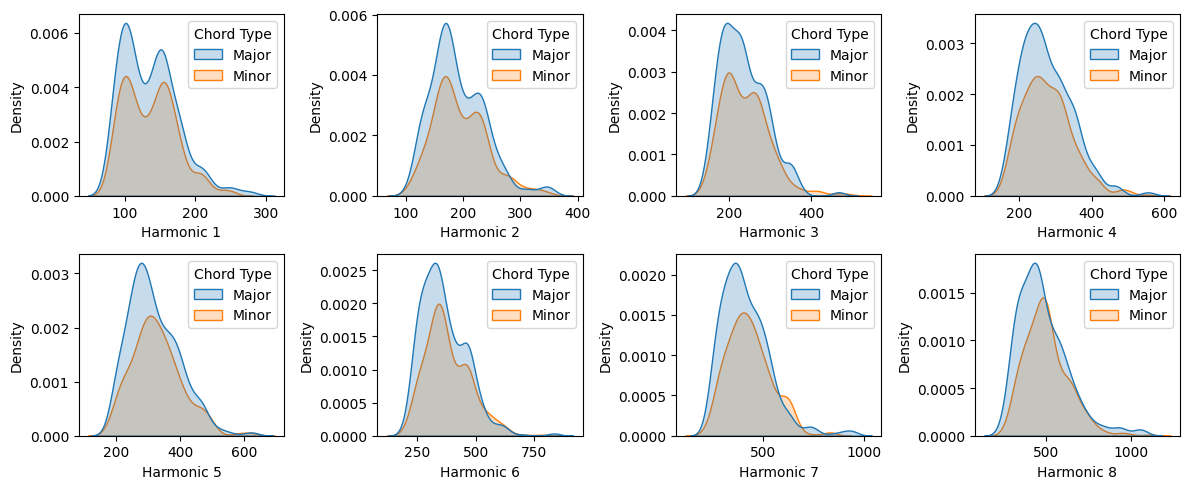

In [262]:
# Plot Harmonics to explore their difference
fig, axes = plt.subplots(2, 4, figsize=(12, 5))
axes = axes.flatten()  

for i in range(1, 9):
    interval_col_name = f"Harmonic {i}"
    sns.kdeplot(ax=axes[i-1], data=df, x=interval_col_name, hue="Chord Type", fill=True)

fig.tight_layout()
plt.show()

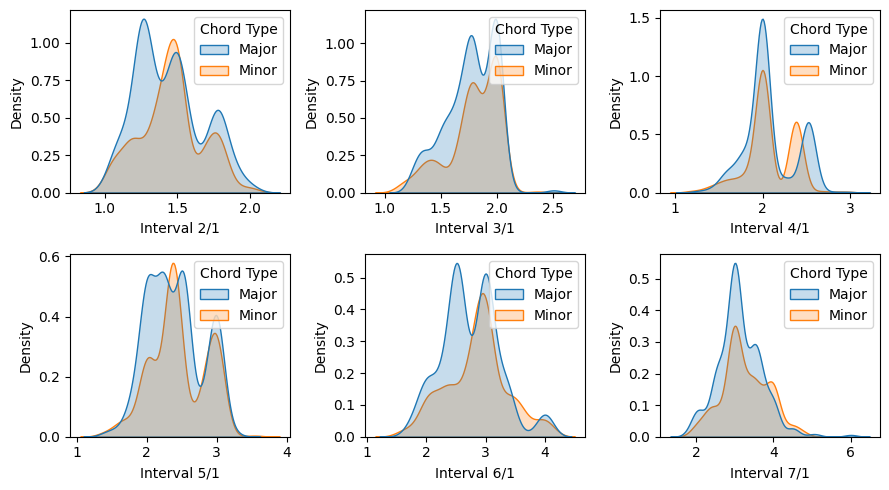

In [263]:
# Plot Intervals to explore their difference
for i in range(2, 9):
    interval_col_name = f"Interval {i}/1"
    harmonic_col_name = f"Harmonic {i}"
    df[interval_col_name] = df[harmonic_col_name].div(df["Harmonic 1"], axis=0)

# Plot KDE plots using a loop with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(9, 5))
axes = axes.flatten()  # Flatten the 2D array of subplots for easier indexing

for i in range(2, 8):
    interval_col_name = f"Interval {i}/1"
    sns.kdeplot(ax=axes[i-2], data=df, x=interval_col_name, hue="Chord Type", fill=True)

fig.tight_layout()
plt.show()

## Find Extemely different intervals
- We can see that the Harmonics are almost have same distribution shape for Major and Minor, so we can't use the Harmonics feature to classify them.
- For Invervals, we can see that a few intervals have great differences between Major and Minor, let's explore more intervals.

### Nearby Harmonic Intervals

In [264]:
df = df_original.copy() # refreshing df

for i in range(1,21):
    curr_interval = "Interval {}".format(i)
    curr_harm = "Harmonic {}".format(i+1)
    prev_harm = "Harmonic {}".format(i)
    df[curr_interval] = df[curr_harm].div(df[prev_harm], axis=0)
    
df.head()

Chord Type      File Name  Min Harmonic  Max Harmonic  # of Harmonics  \
0      Major  Major_500.wav        116.82       2102.27              27   
1      Major  Major_266.wav        109.78       1949.33              26   
2      Major  Major_272.wav        109.78       1949.33              26   
3      Major  Major_299.wav        147.11        741.78              12   
4      Major  Major_474.wav        116.89       1960.00              25   

   Harmonic 1  Harmonic 2  Harmonic 3  Harmonic 4  Harmonic 5  ...  \
0      116.82      165.45      221.36      233.64      262.27  ...   
1      109.78      165.33      220.00      247.11      278.22  ...   
2      109.78      165.33      220.00      247.11      278.22  ...   
3      147.11      208.44      233.33      262.22      293.78  ...   
4      116.89      175.11      228.44      234.22      294.67  ...   

   Interval 11  Interval 12  Interval 13  Interval 14  Interval 15  \
0     1.264284     1.058943     1.121036     1.041574     1.007756   
1     1.187711     1.122396     1.040740     1.014974     1.054444   
2     1.187711     1.122396     1.040740     1.075415     1.005360   
3     1.186222          NaN          NaN          NaN          NaN   
4     1.192320     1.115118     1.046506     1.067207     1.010662   

   Interval 16  Interval 17  Interval 18  Interval 19  Interval 20  
0     1.070417     1.121779     1.057726     1.054566     1.046403  
1     1.010227     1.185295     1.124893     1.040732     1.067923  
2     1.185295     1.124893     1.040732     1.067923     1.008263  
3          NaN          NaN          NaN          NaN          NaN  
4     1.060309     1.120849     1.115858     1.005303     1.194876  

[5 rows x 63 columns]

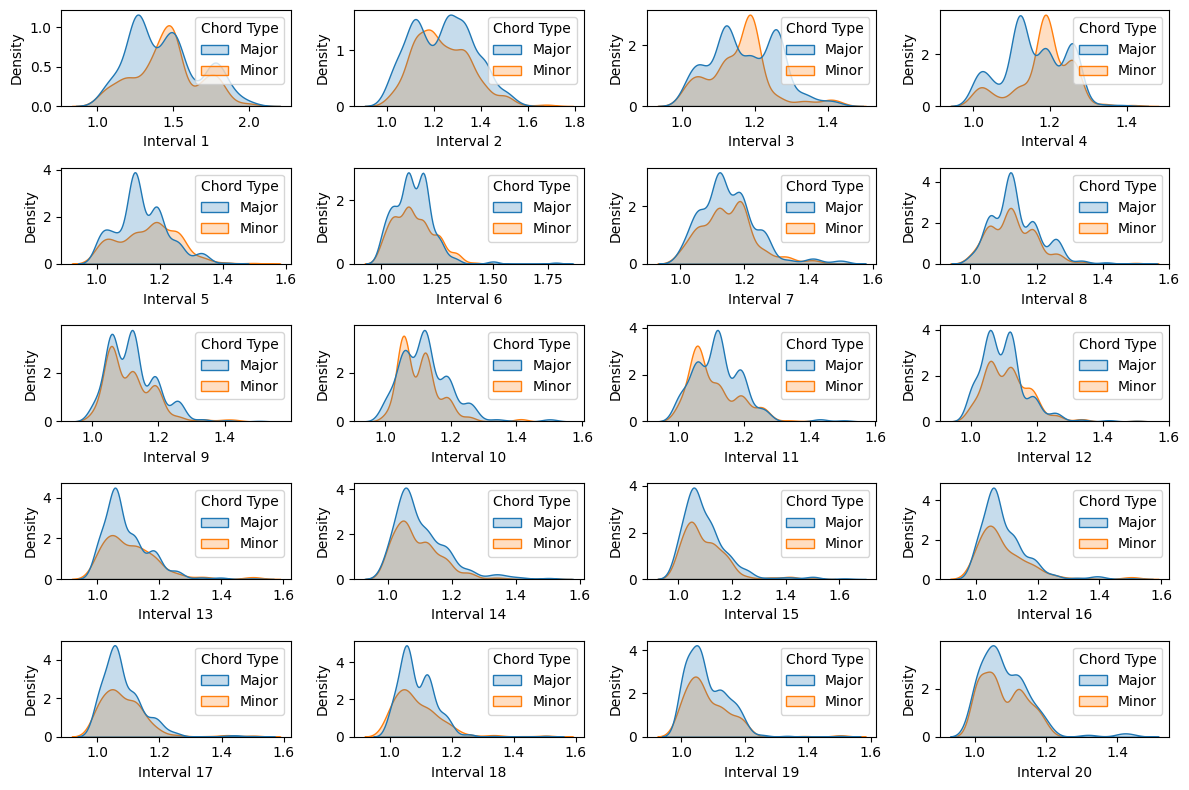

In [265]:
# Lets plot them
fig, axes = plt.subplots(5, 4, figsize=(12, 8))
for i in range(1,21):
    plt.subplot(5, 4, i)
    sns.kdeplot(data=df, x="Interval {}".format(i), hue="Chord Type", fill=True)
fig.tight_layout()
plt.show()

### Whole Intervals

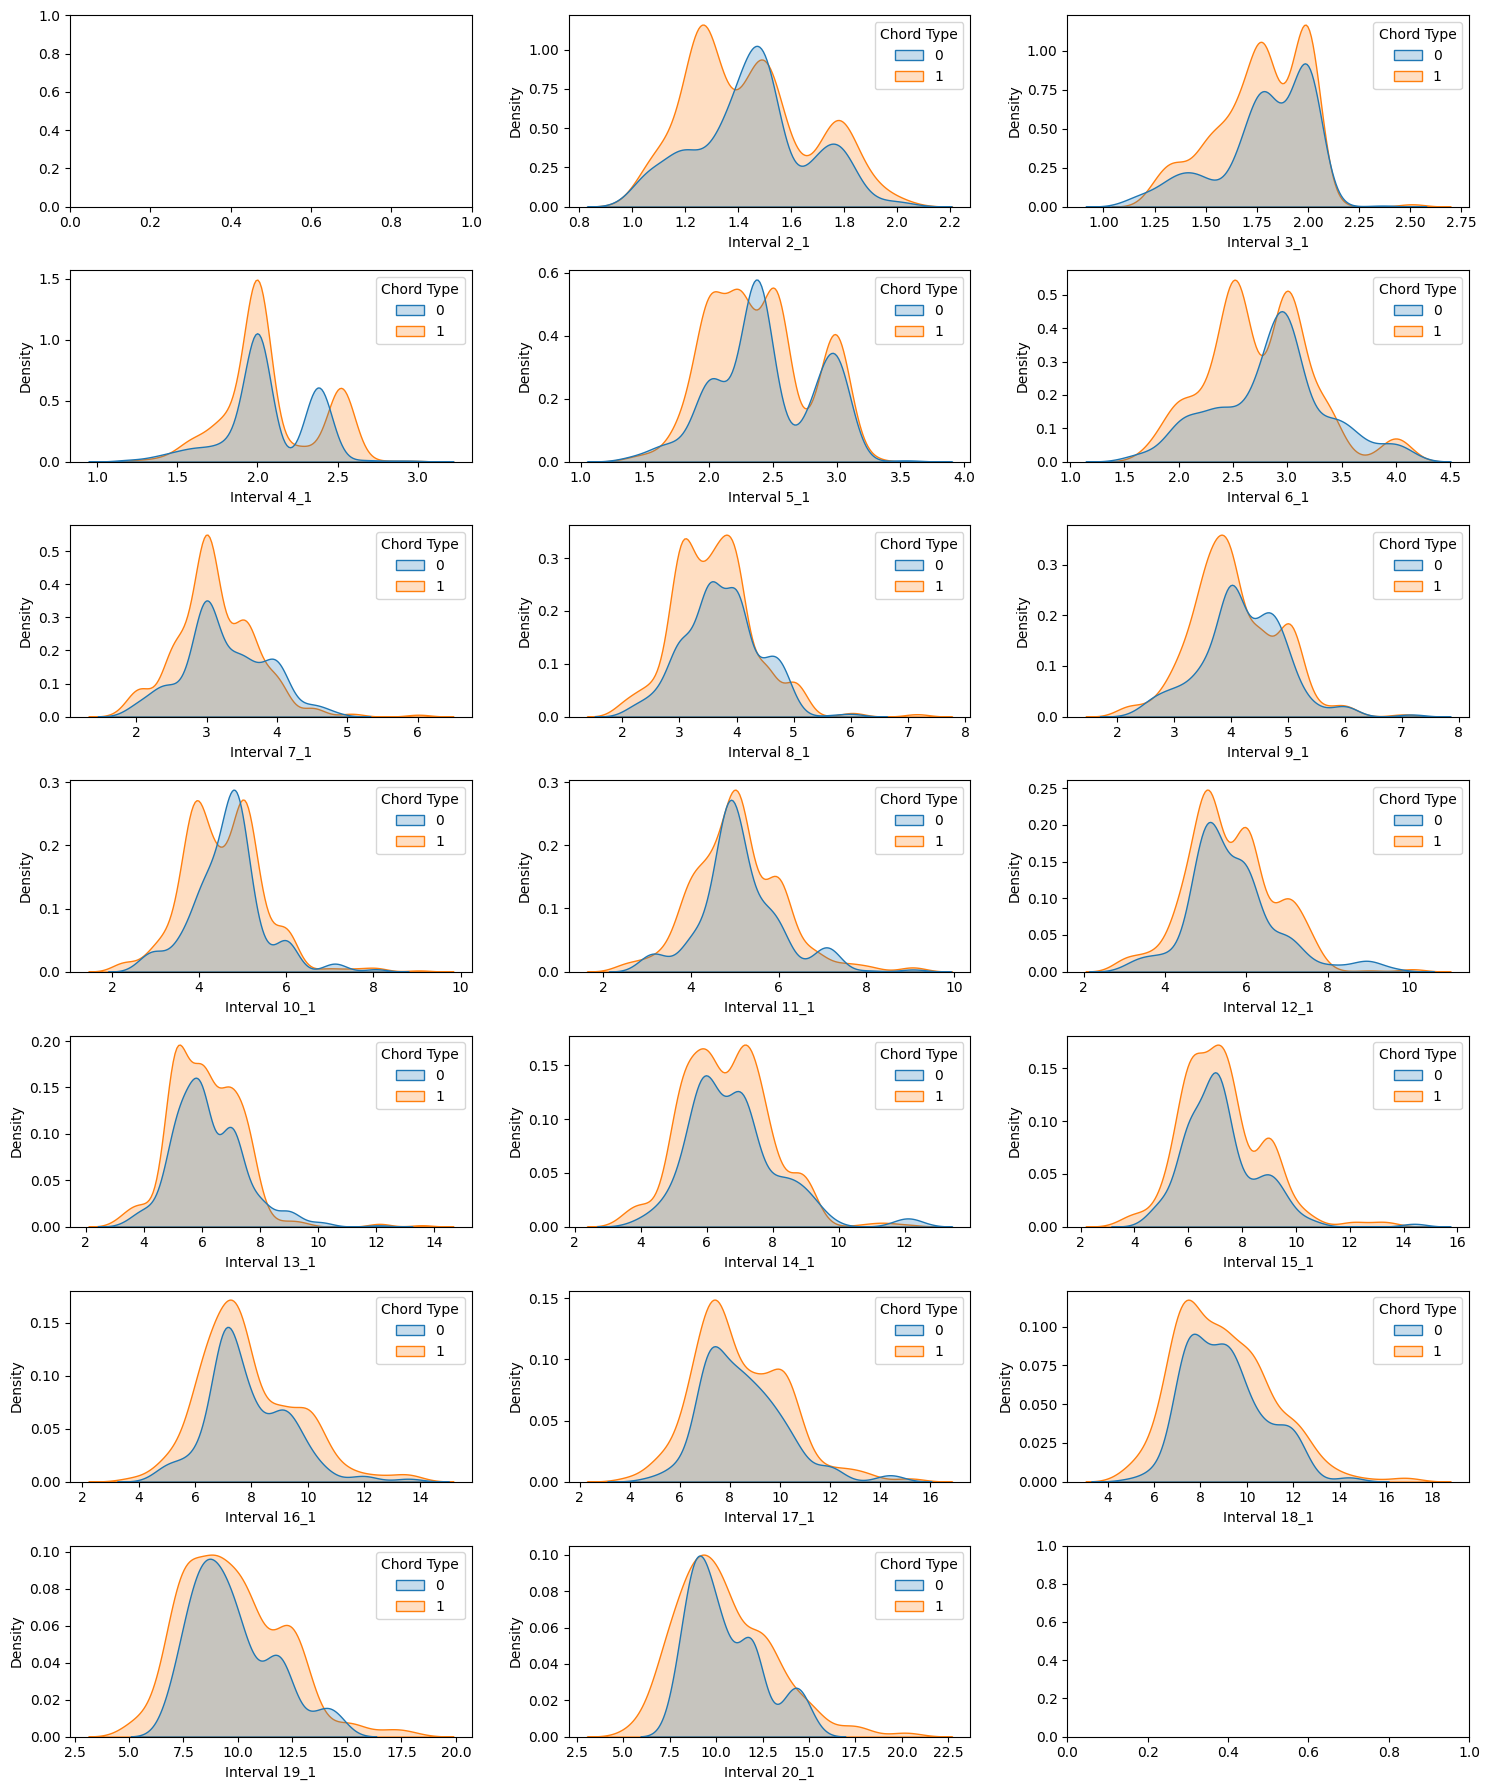

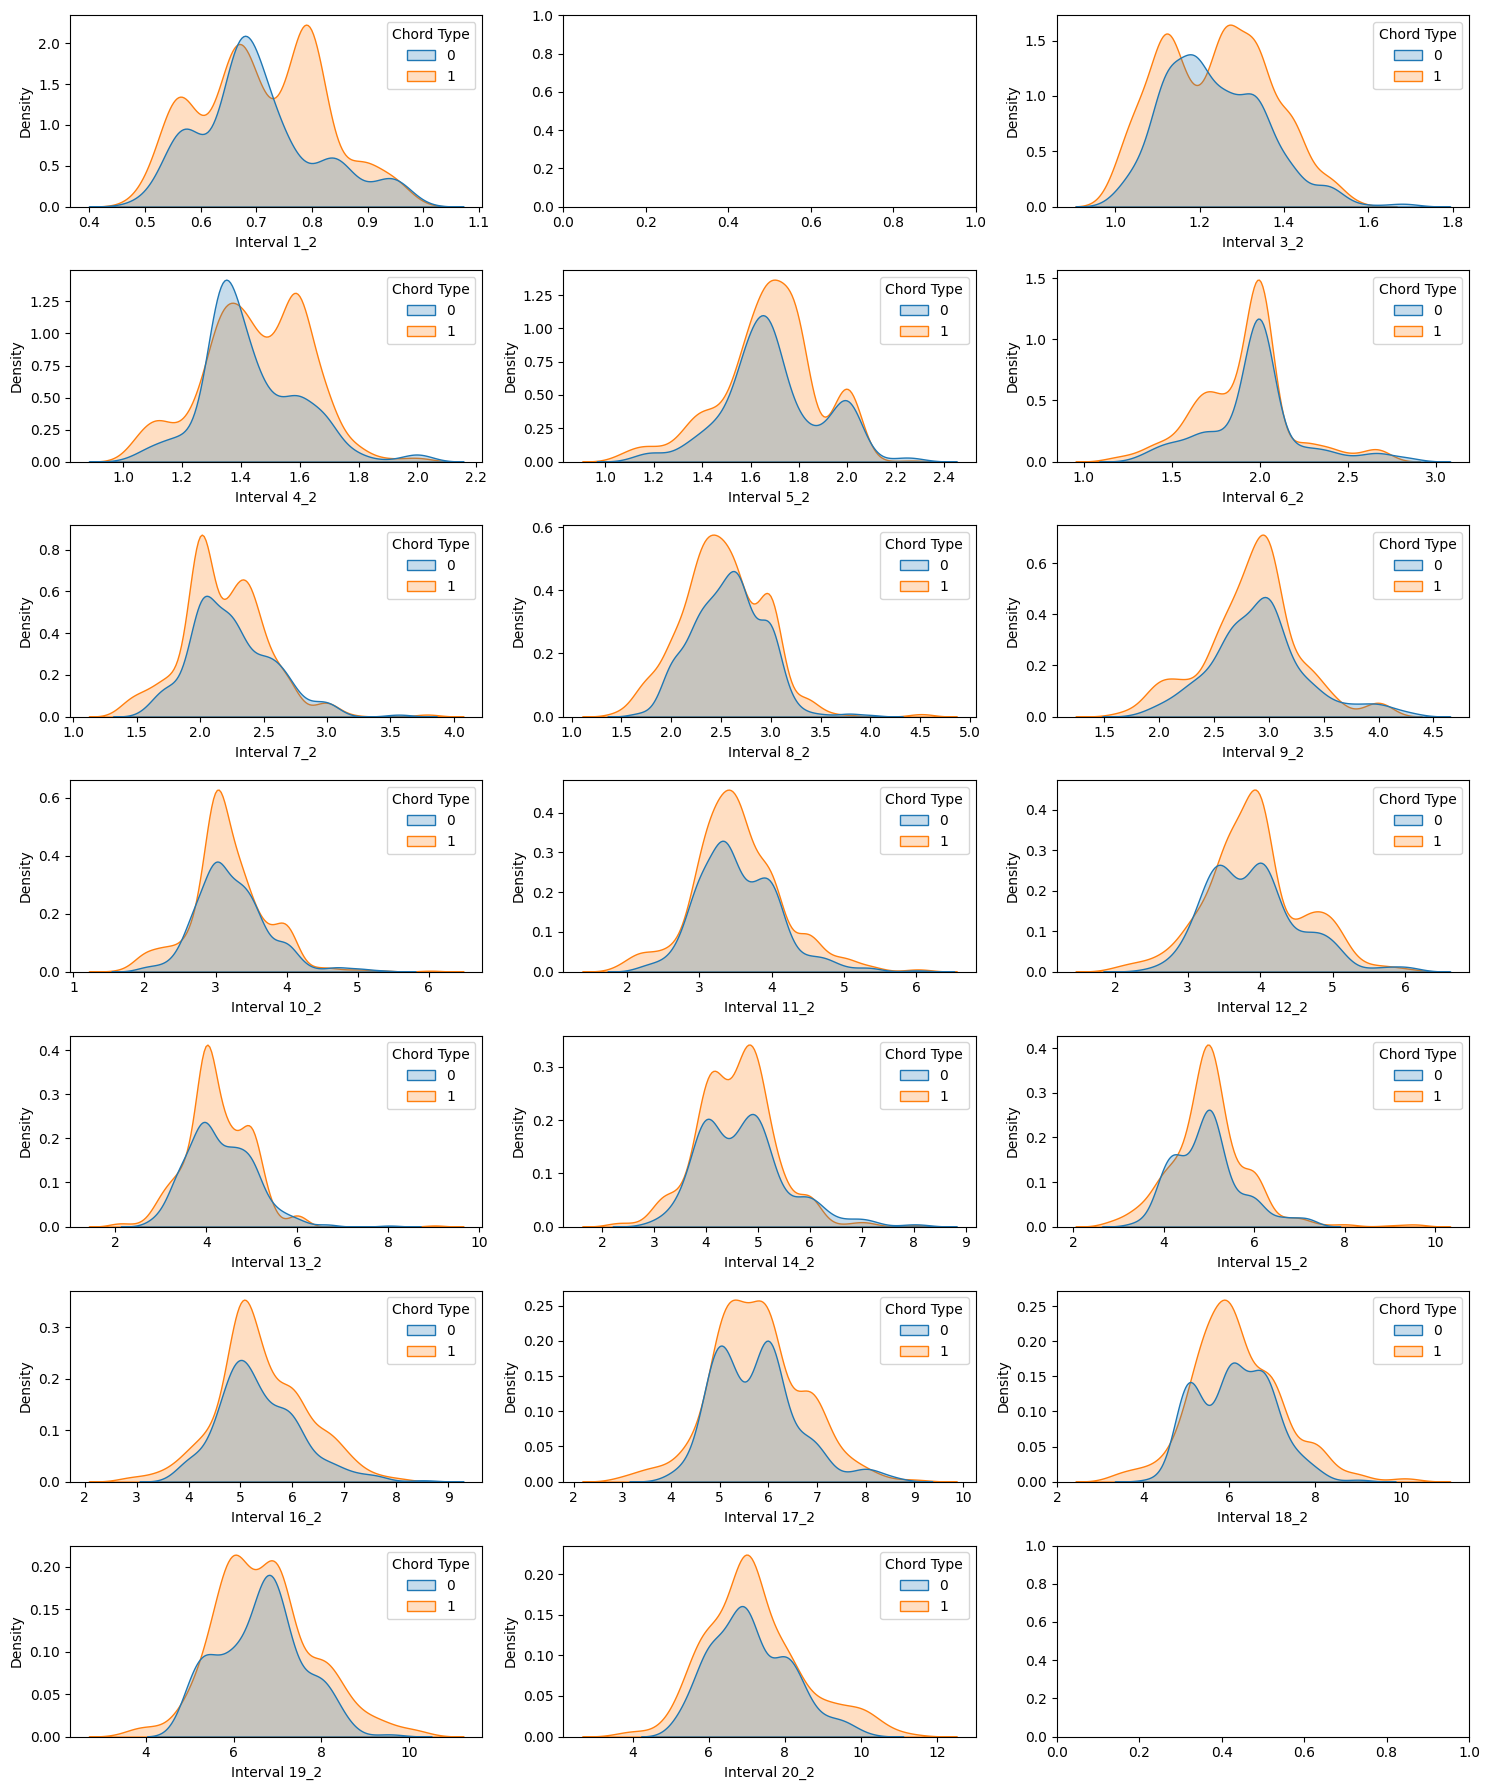

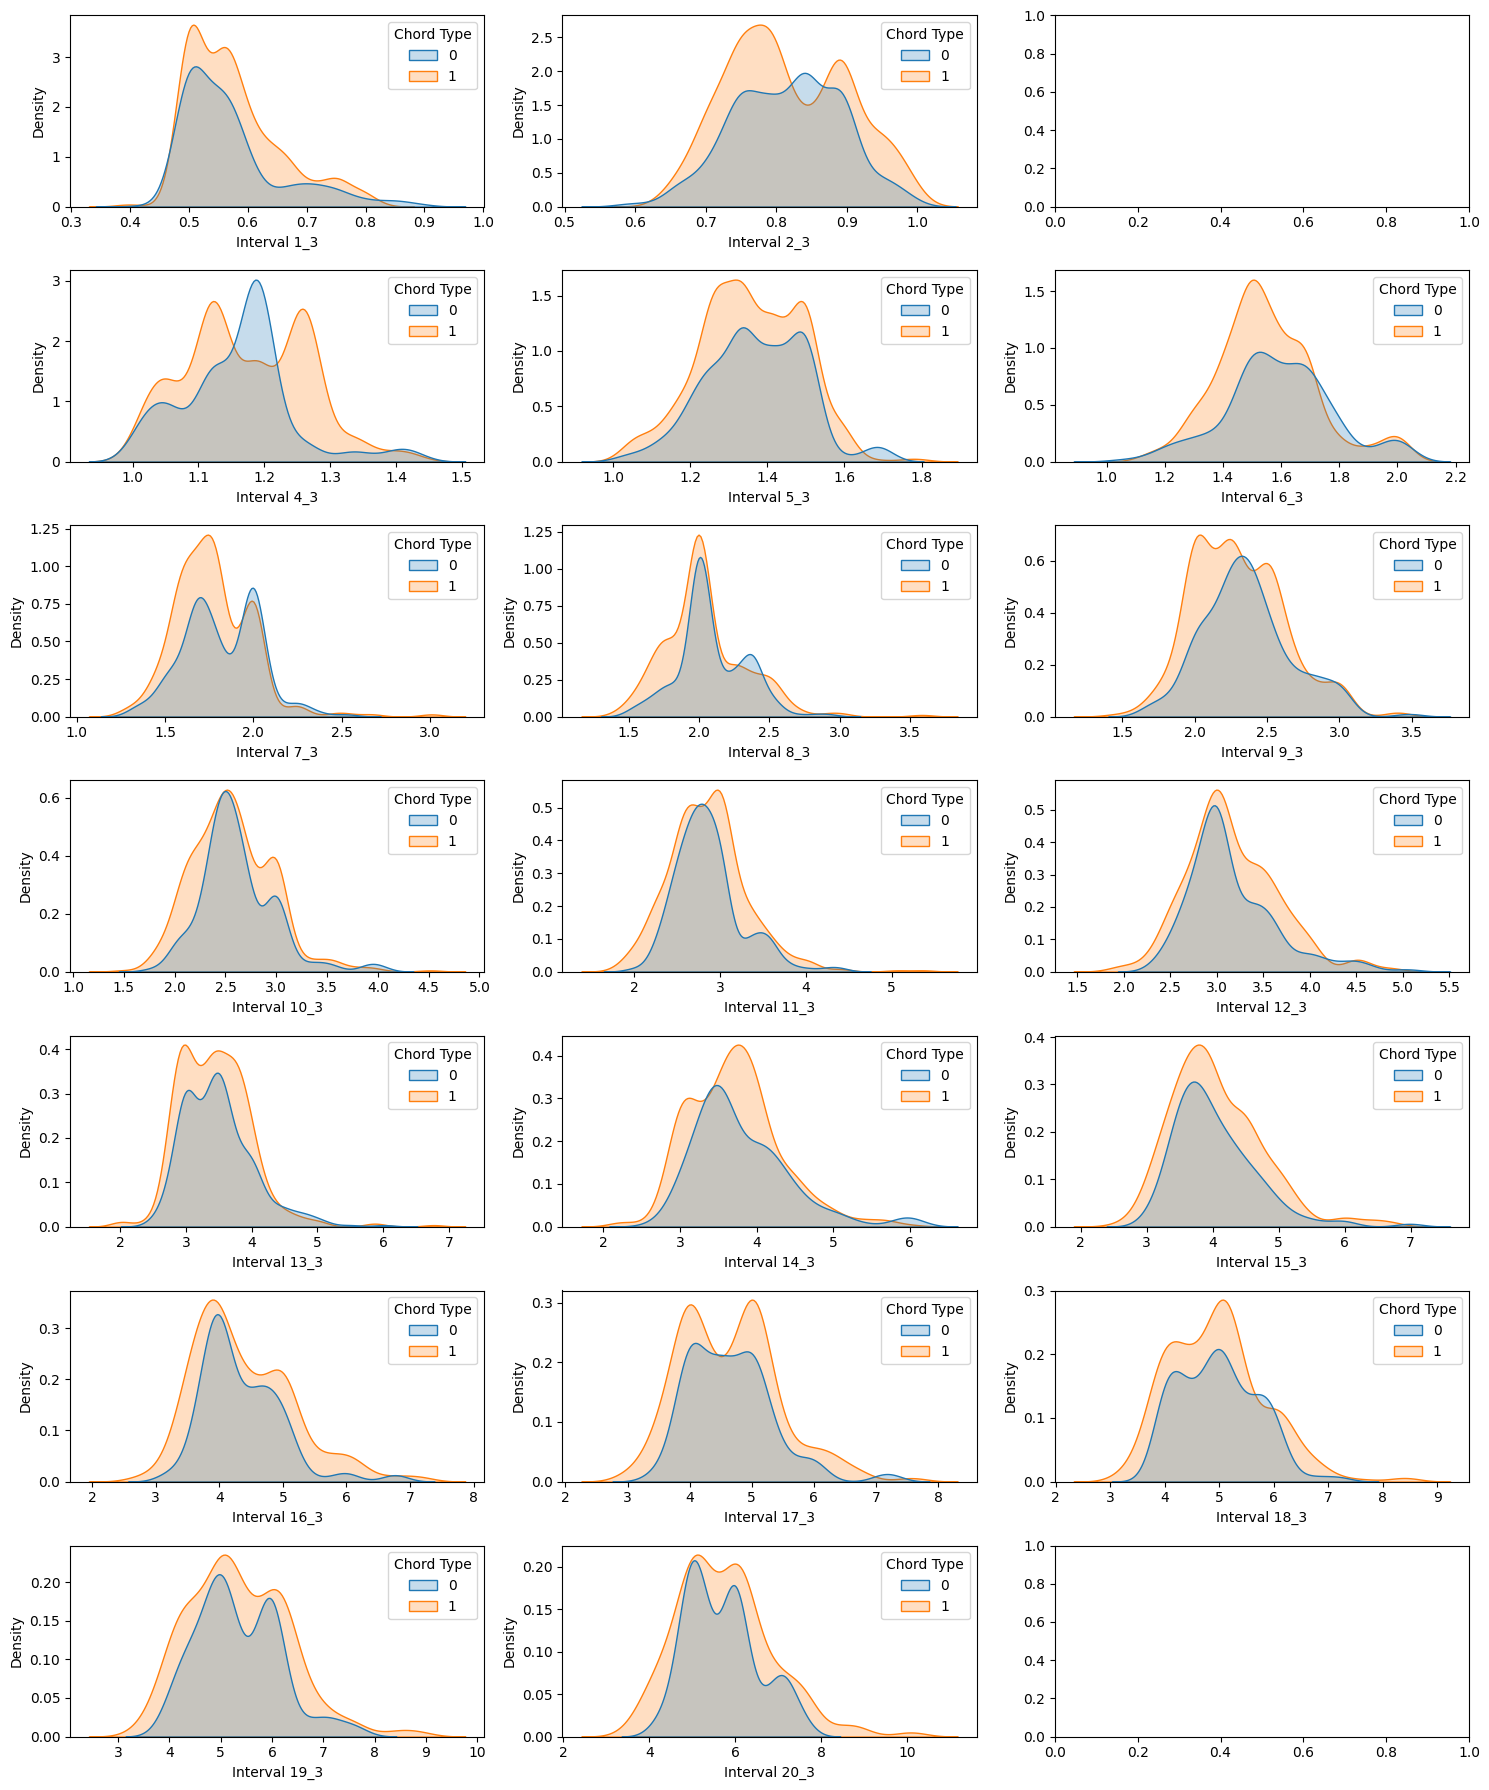

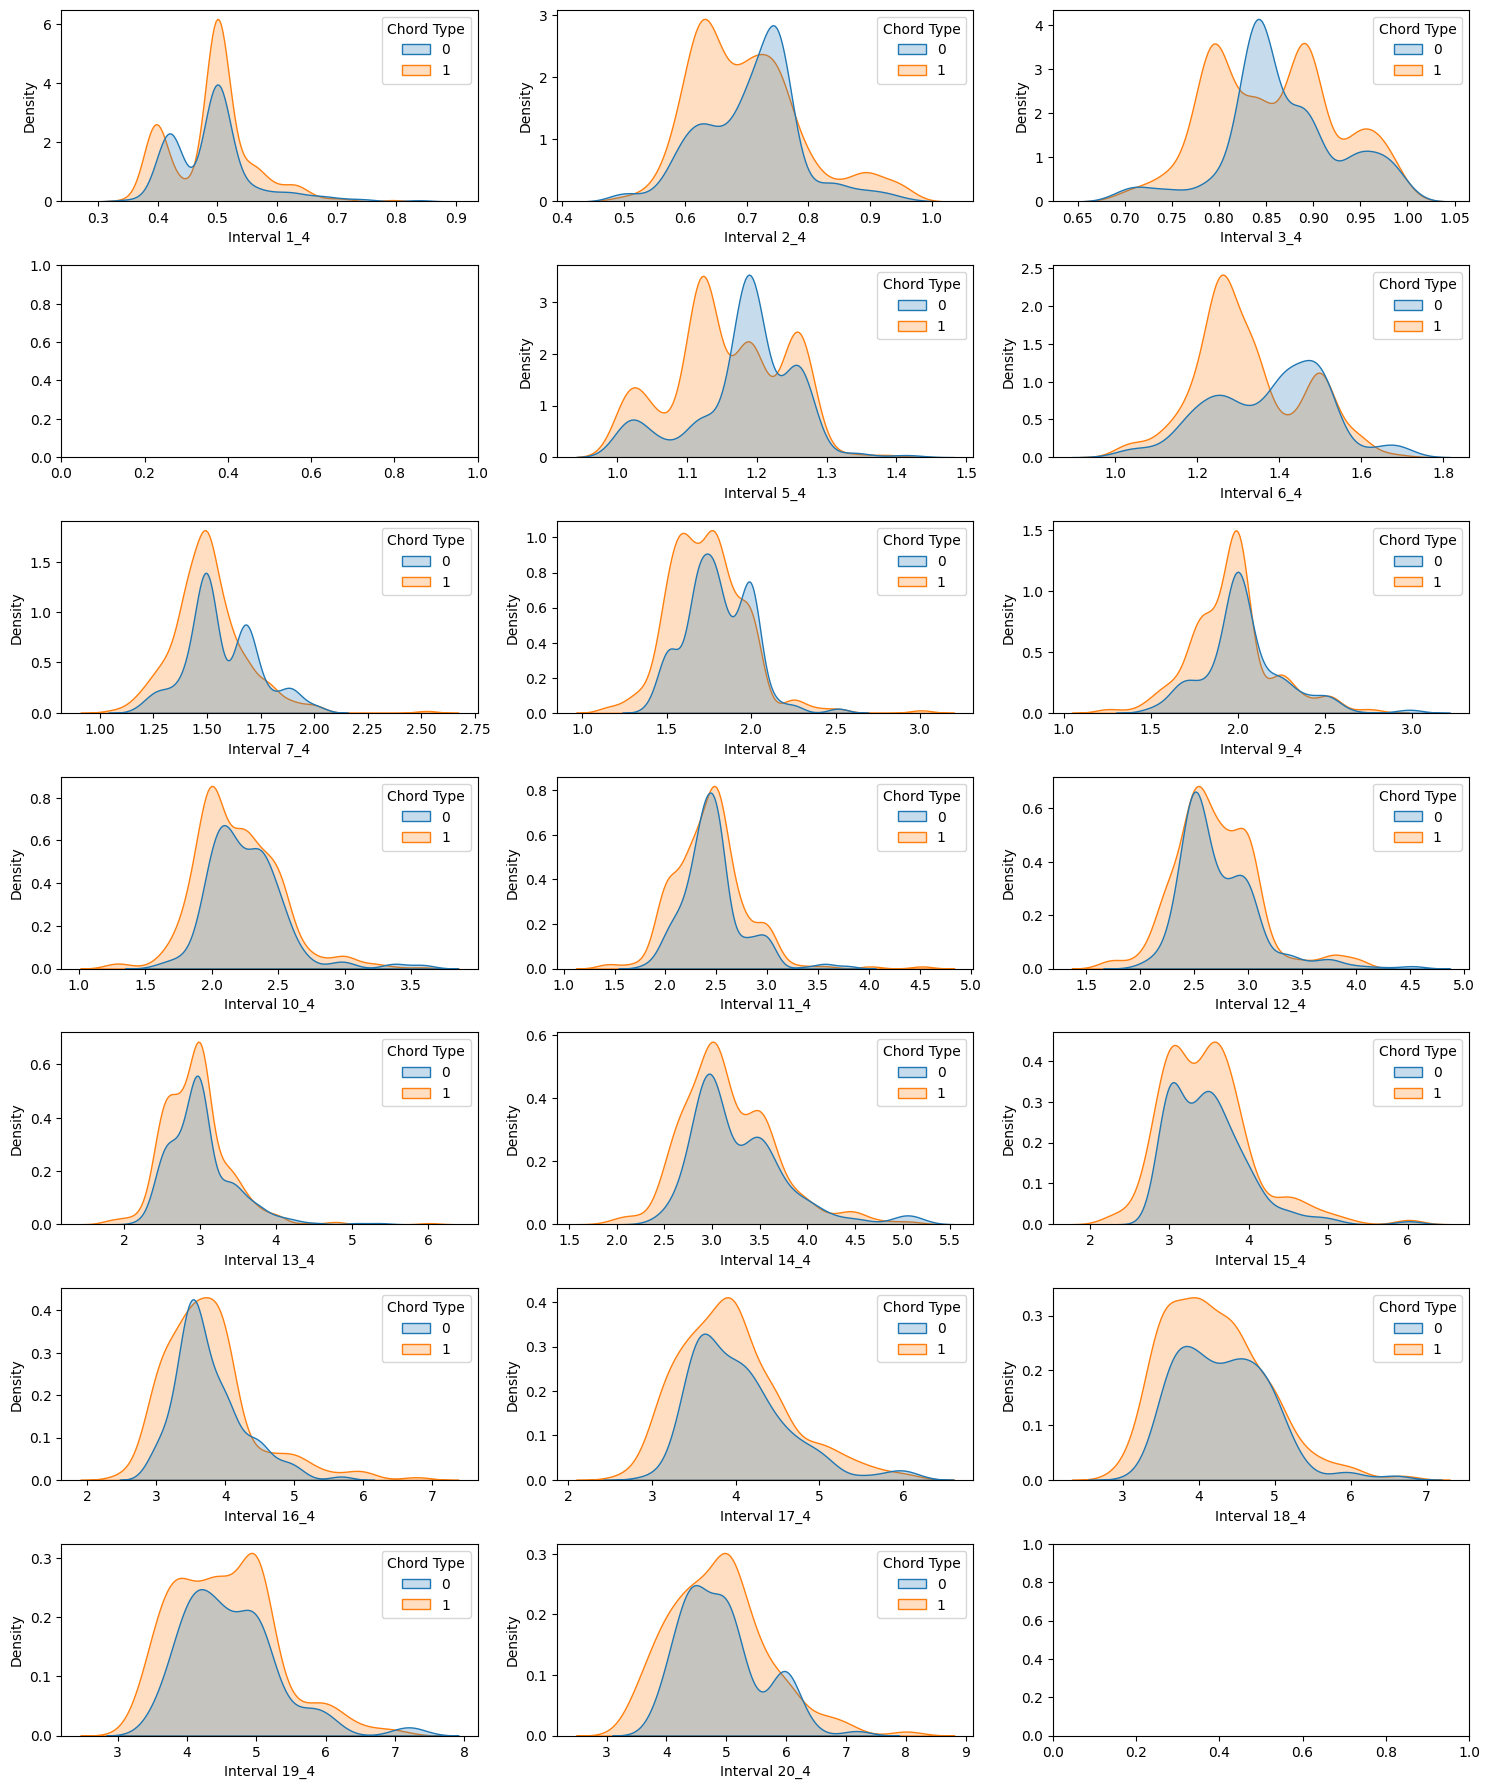

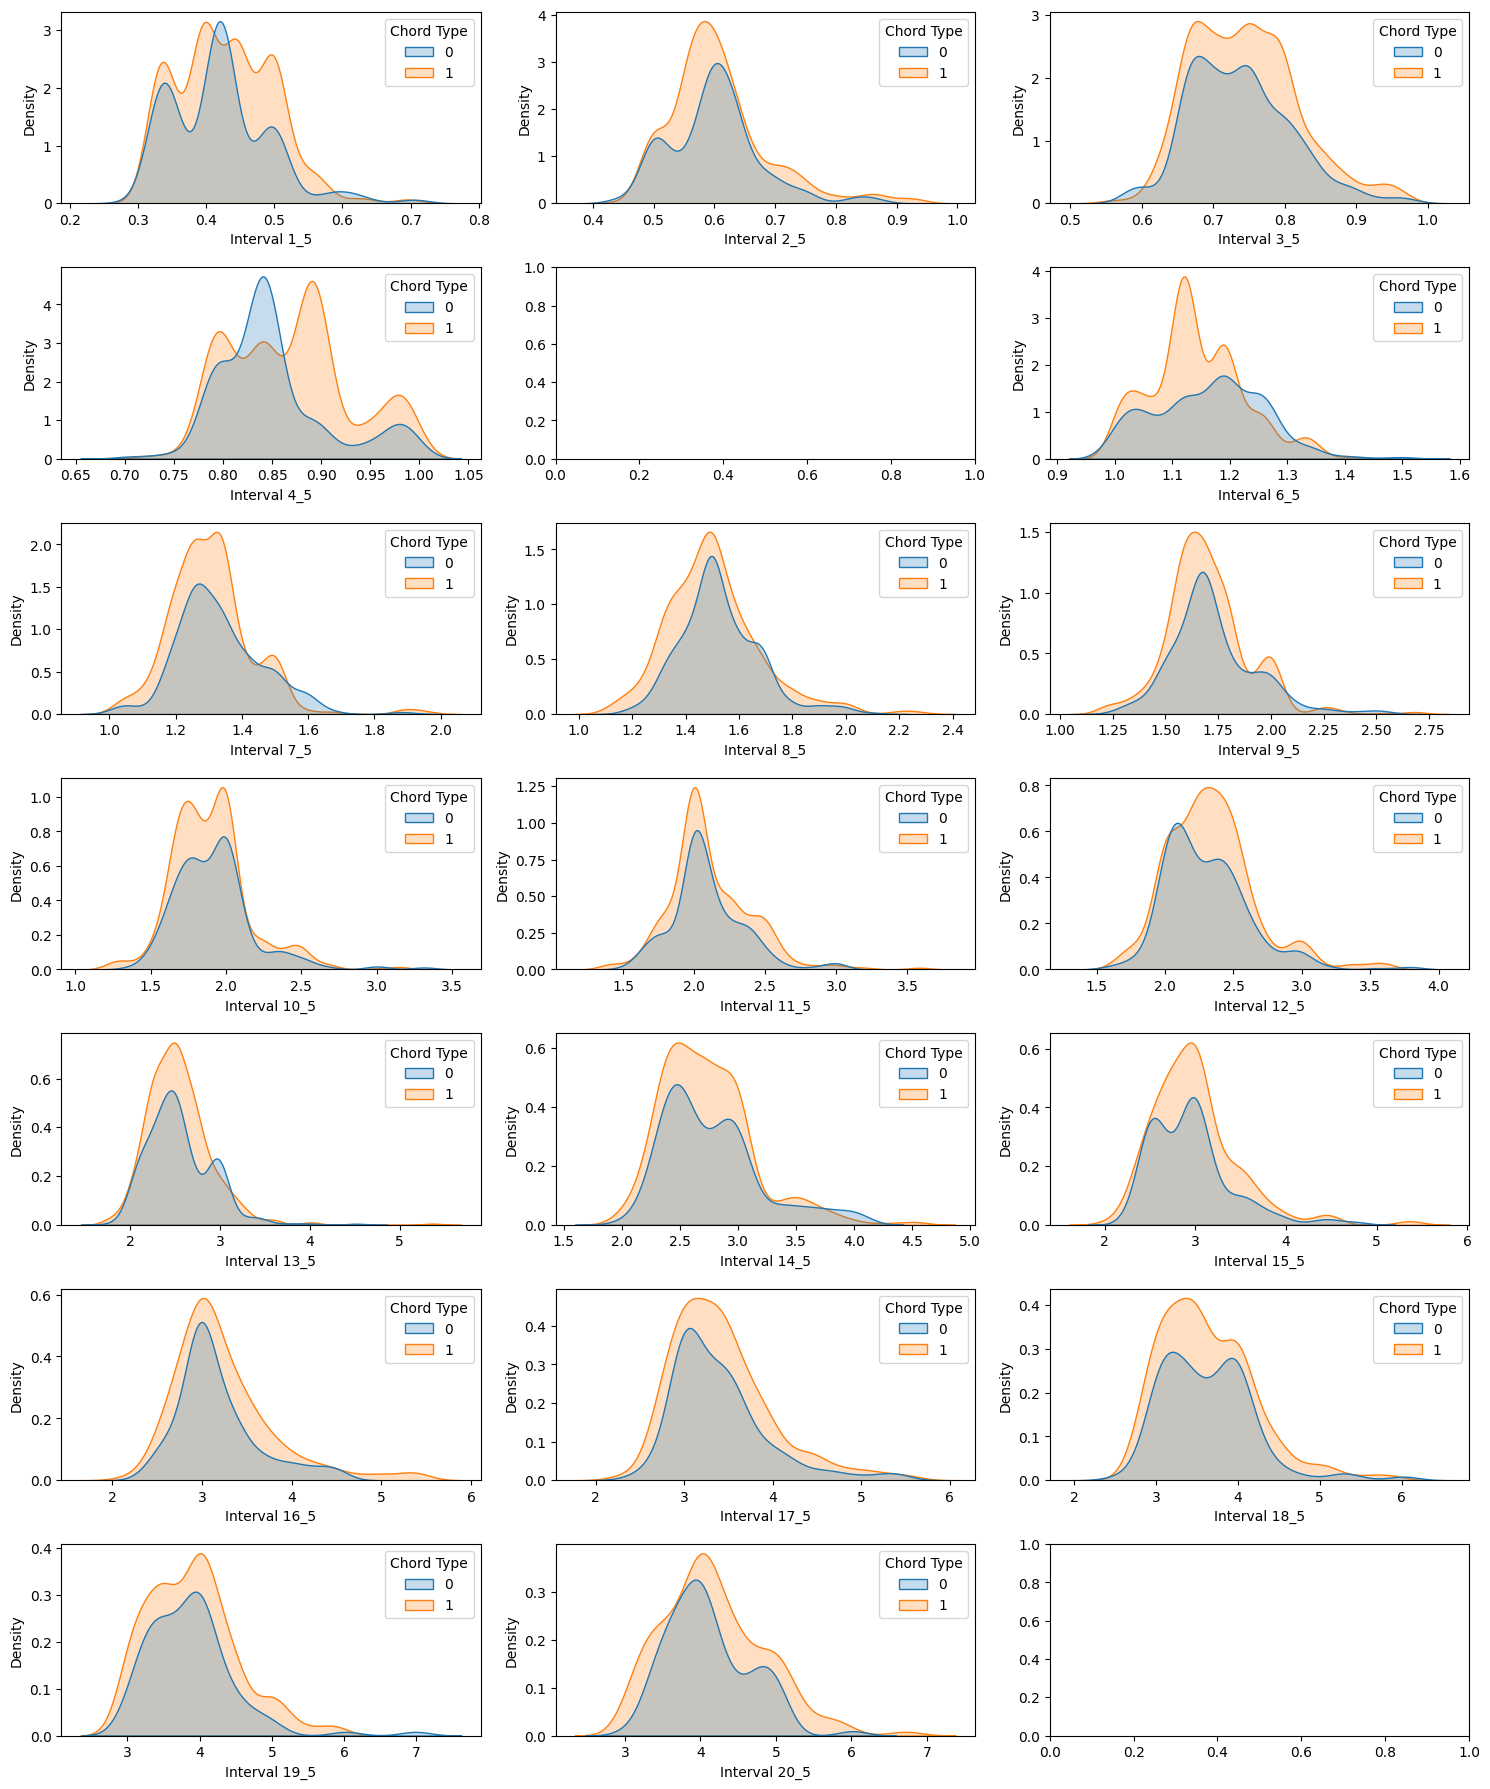

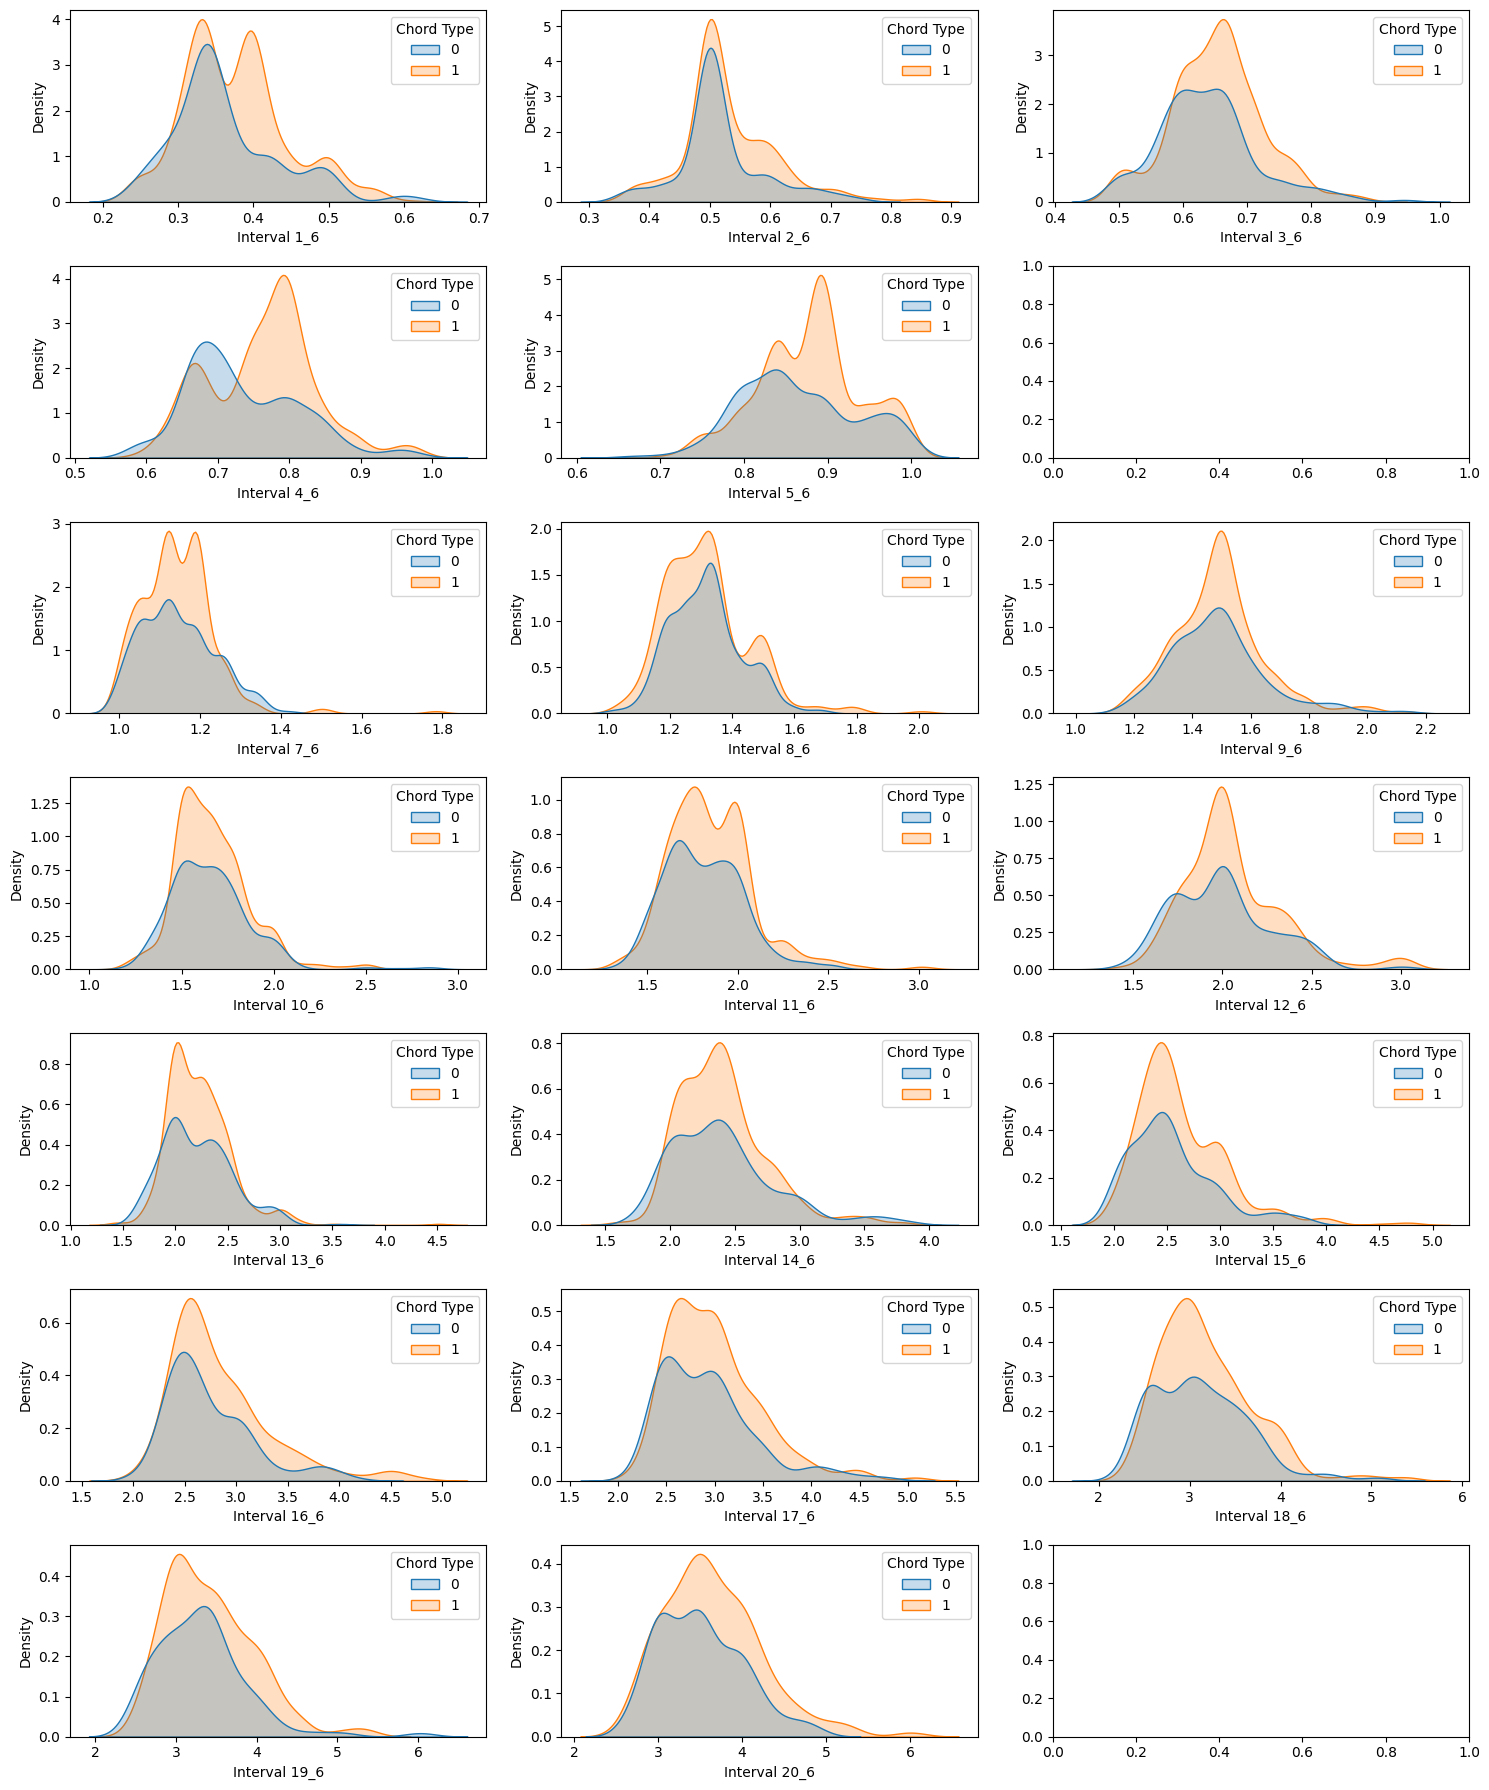

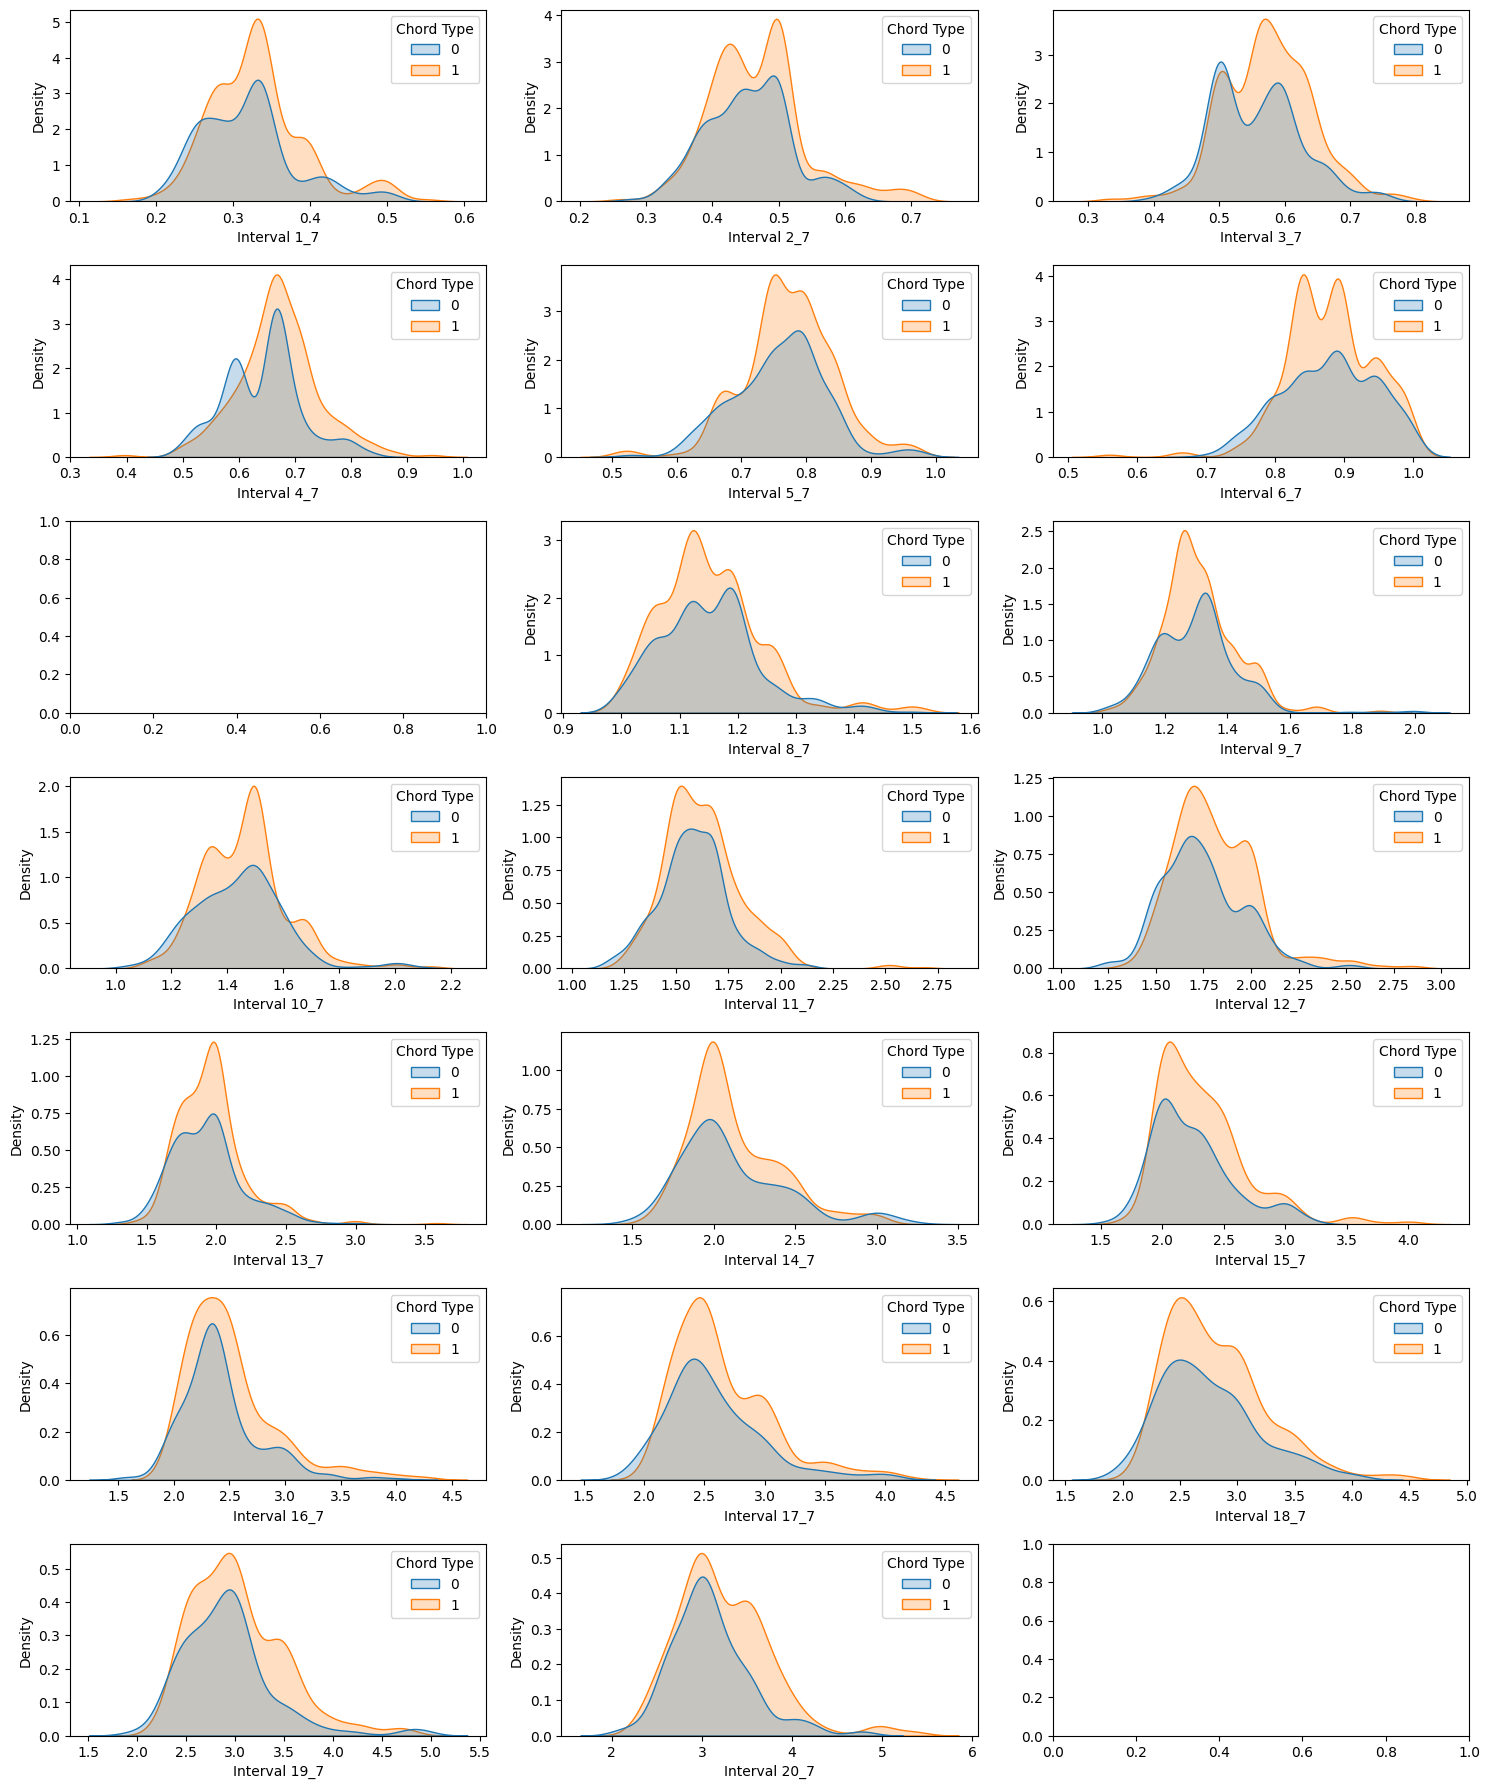

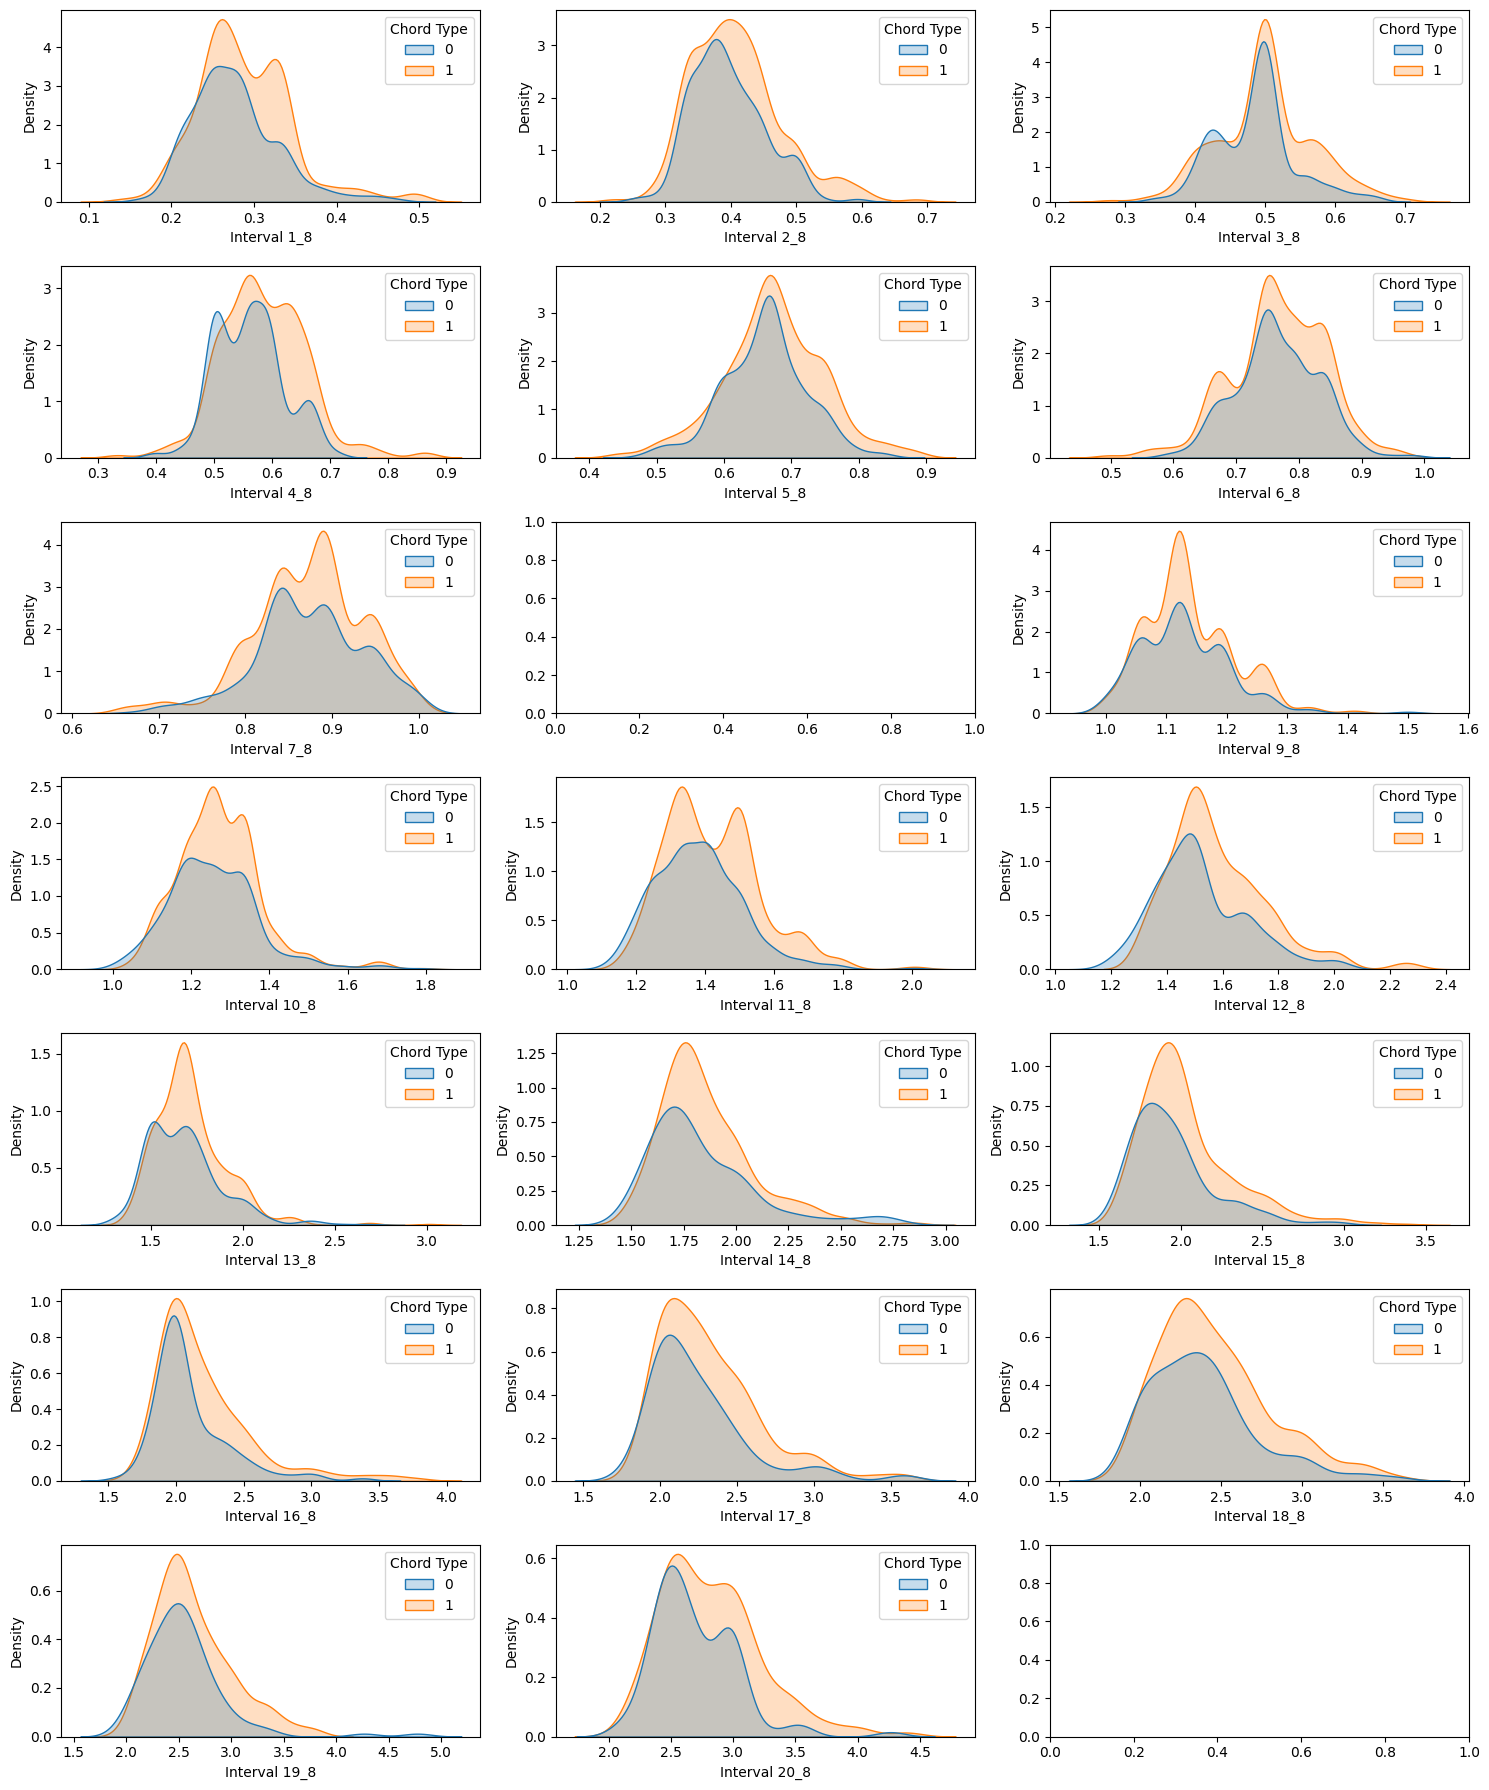

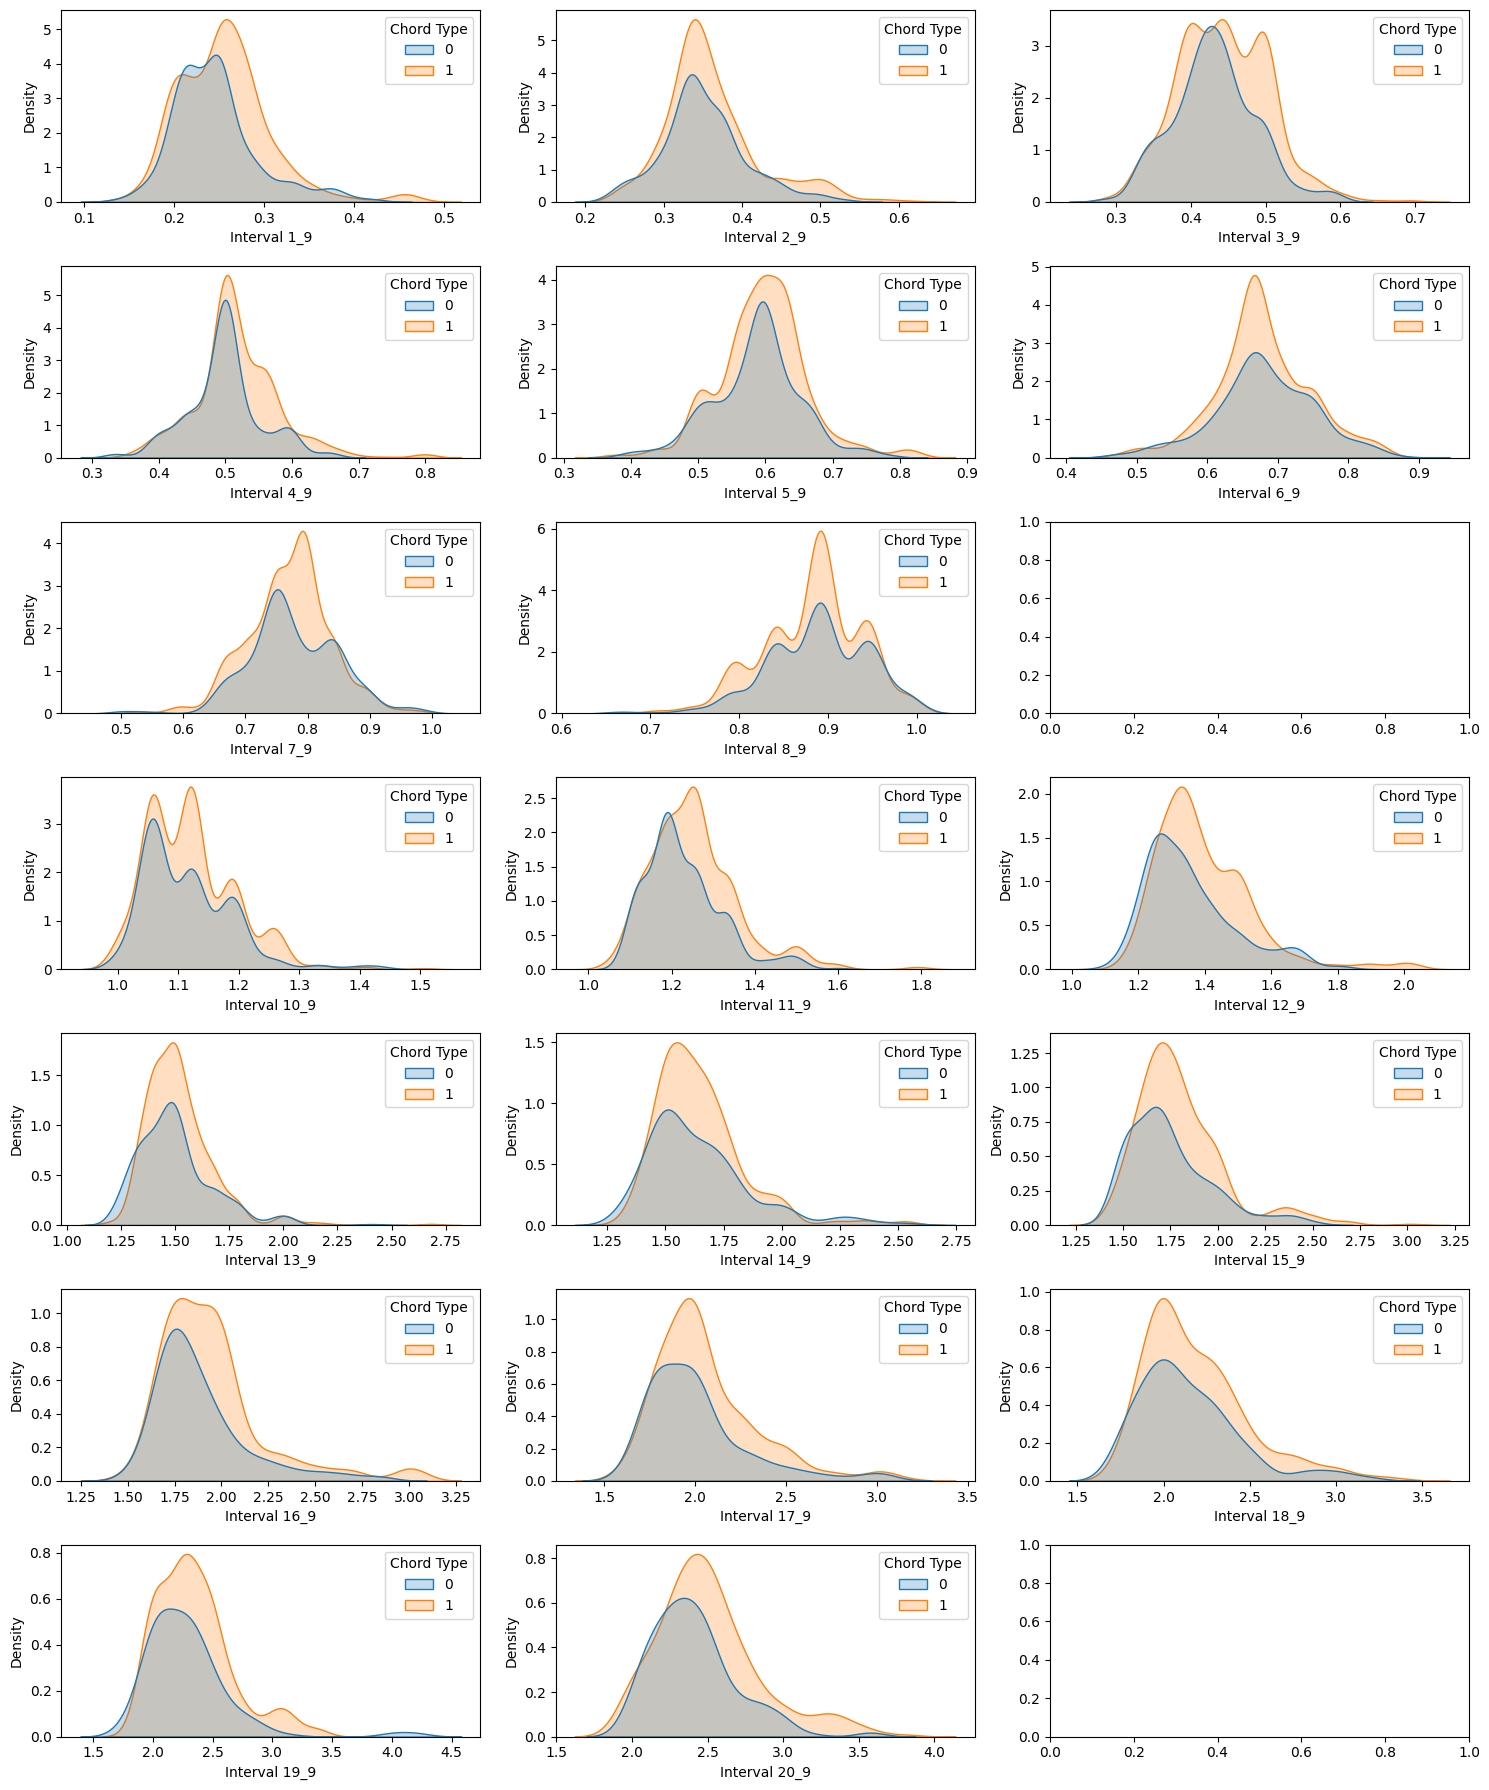

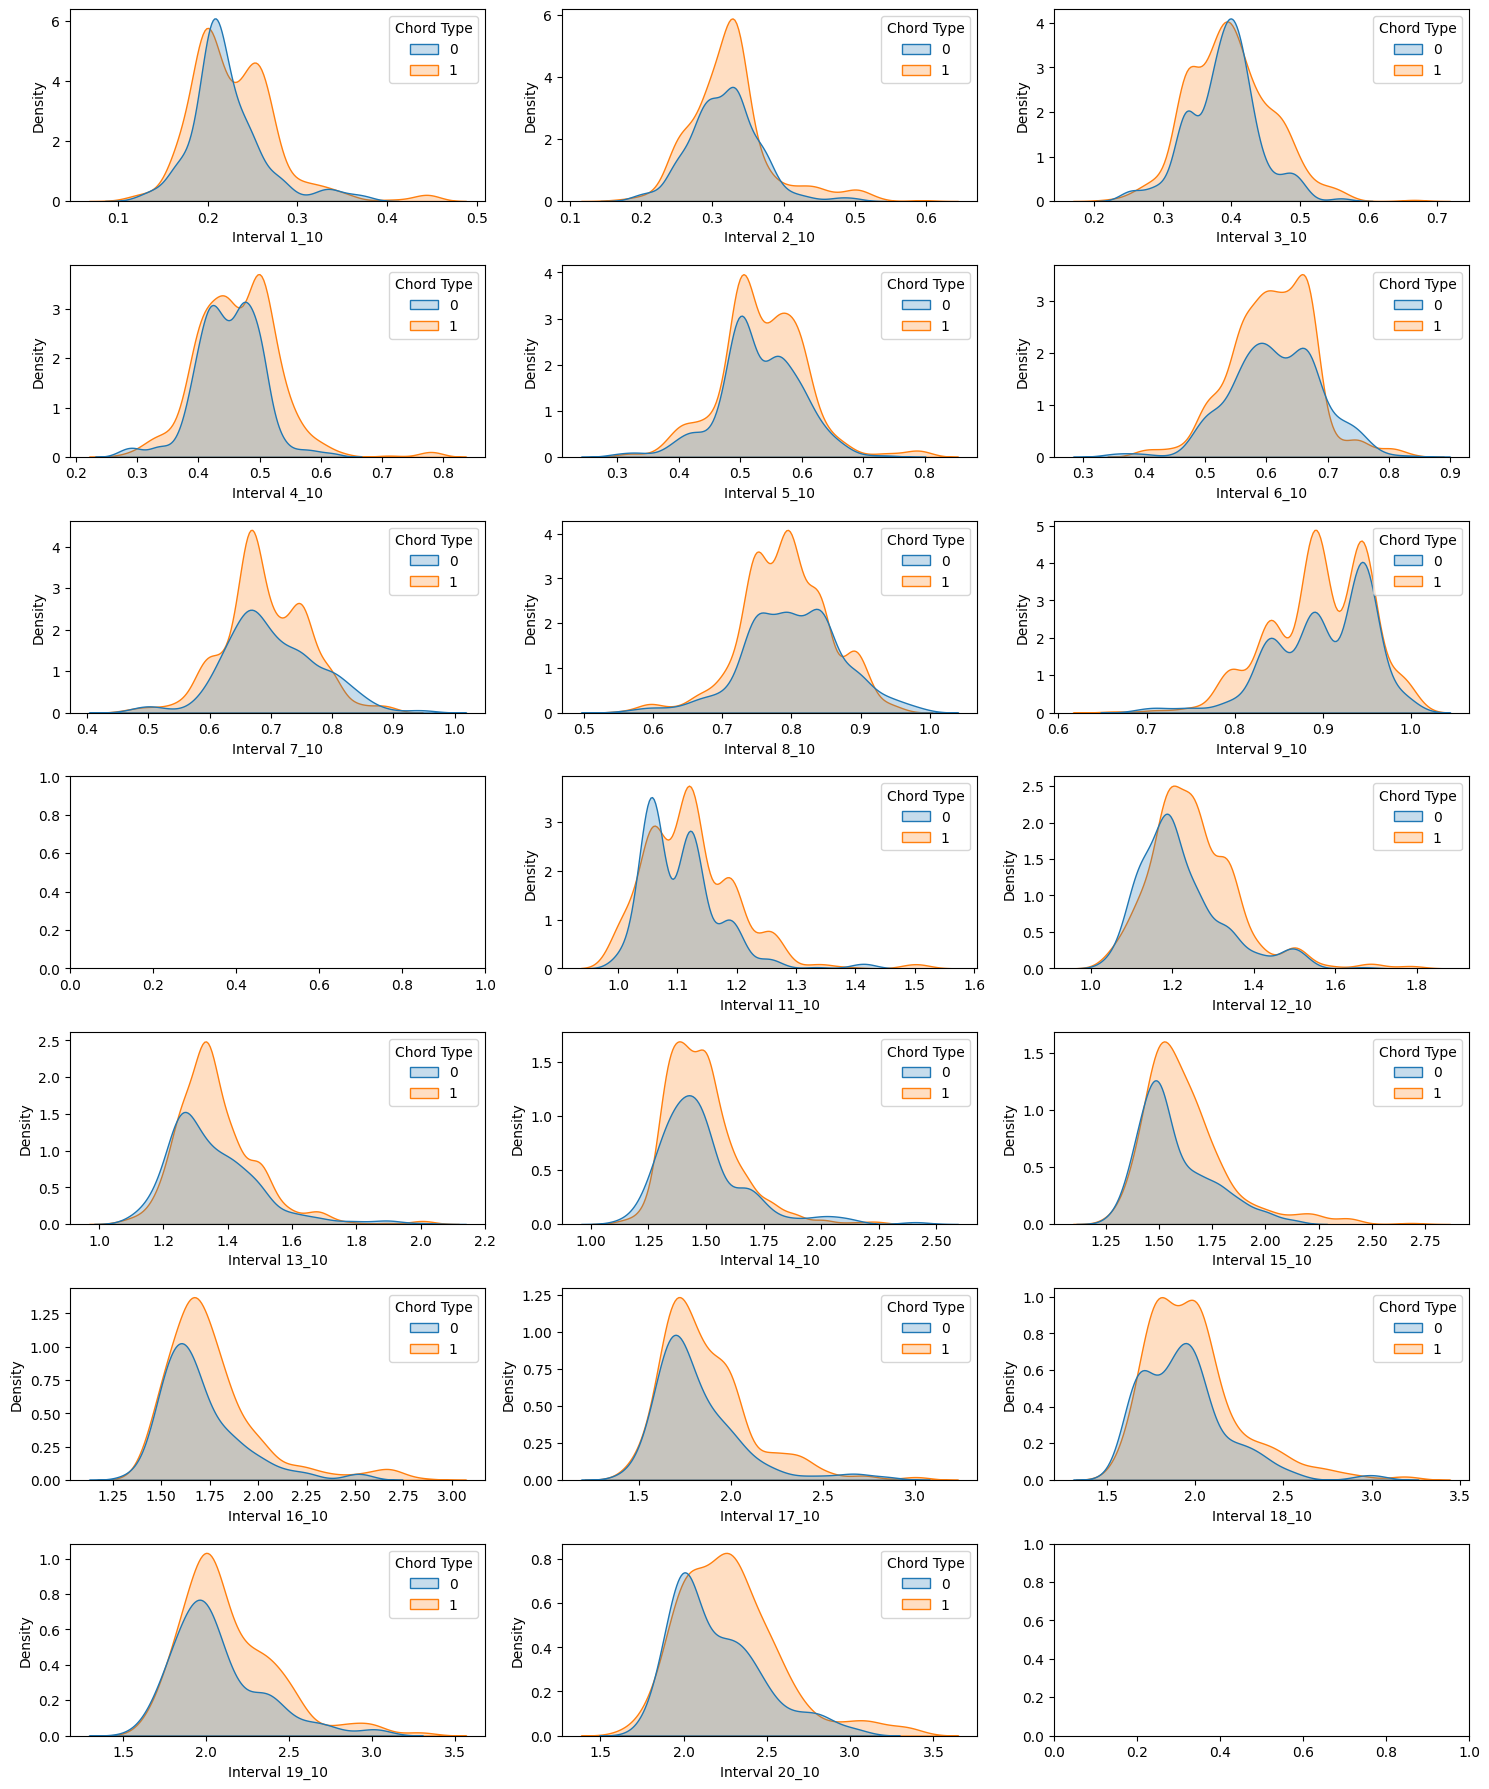

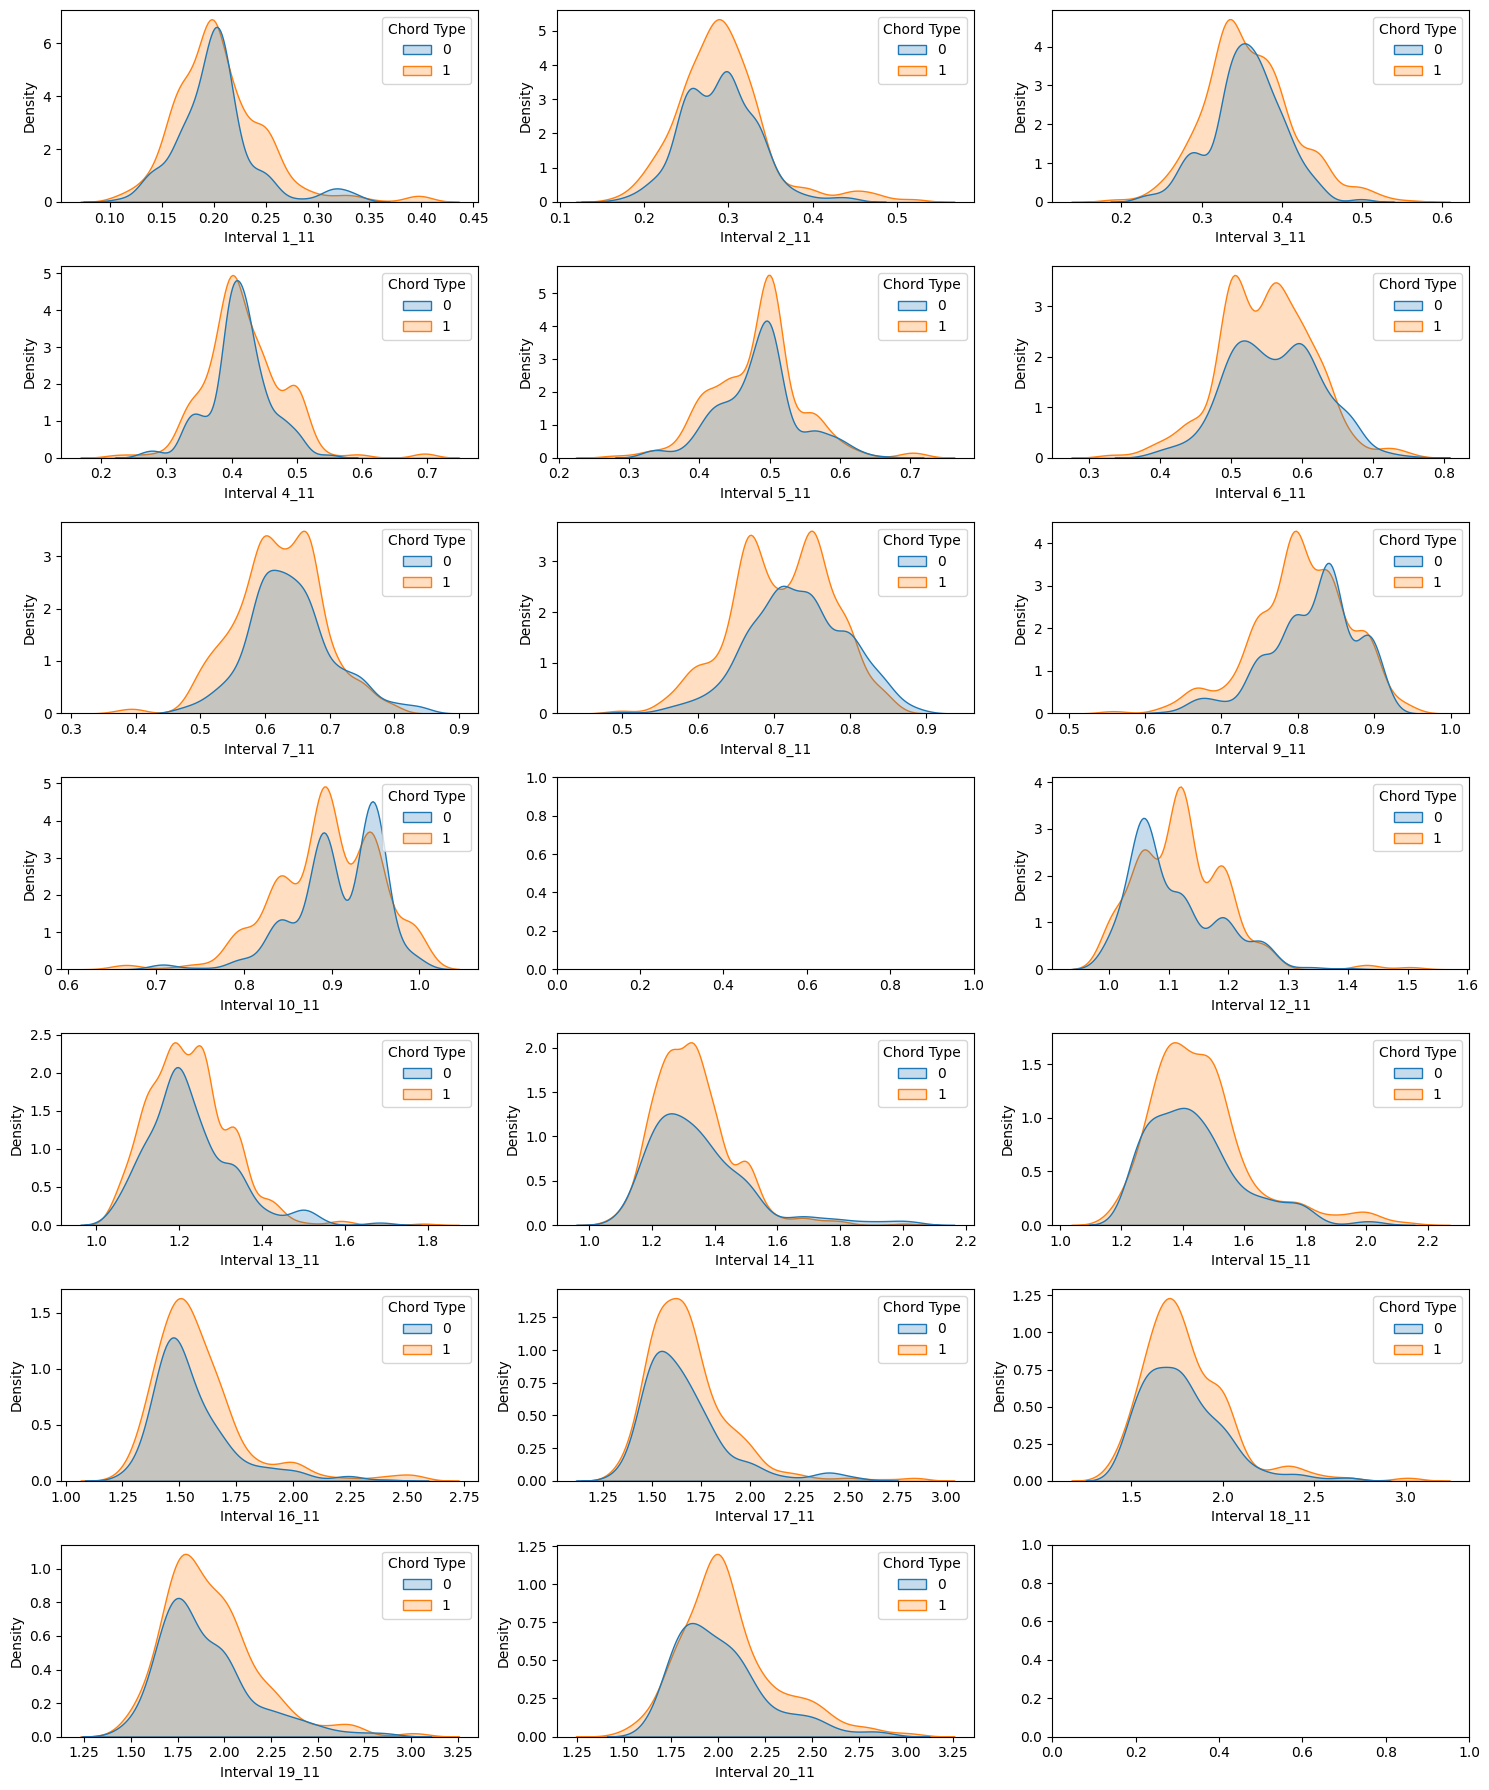

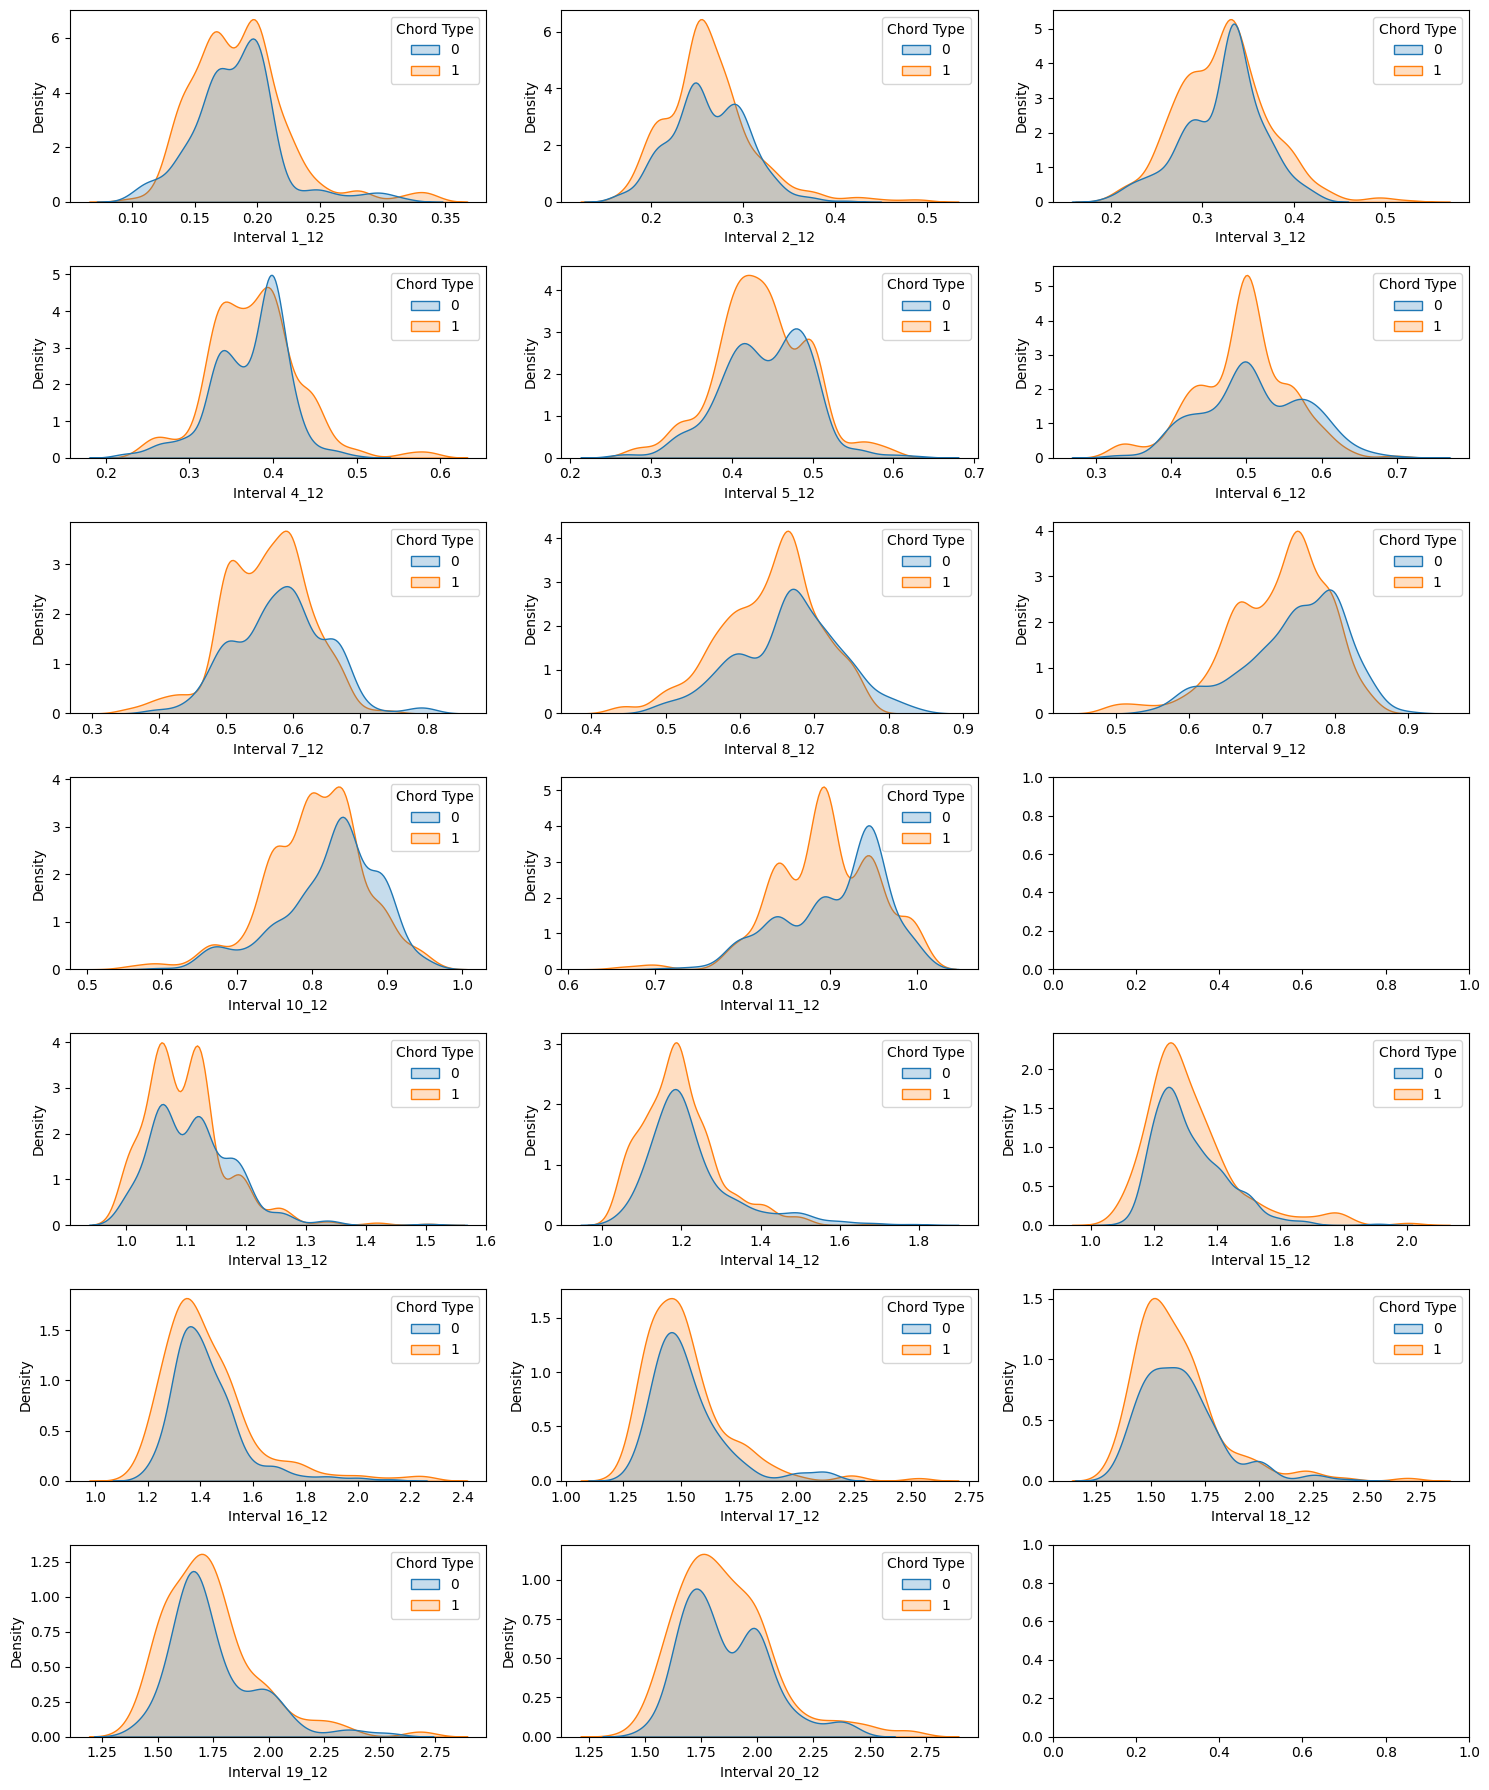

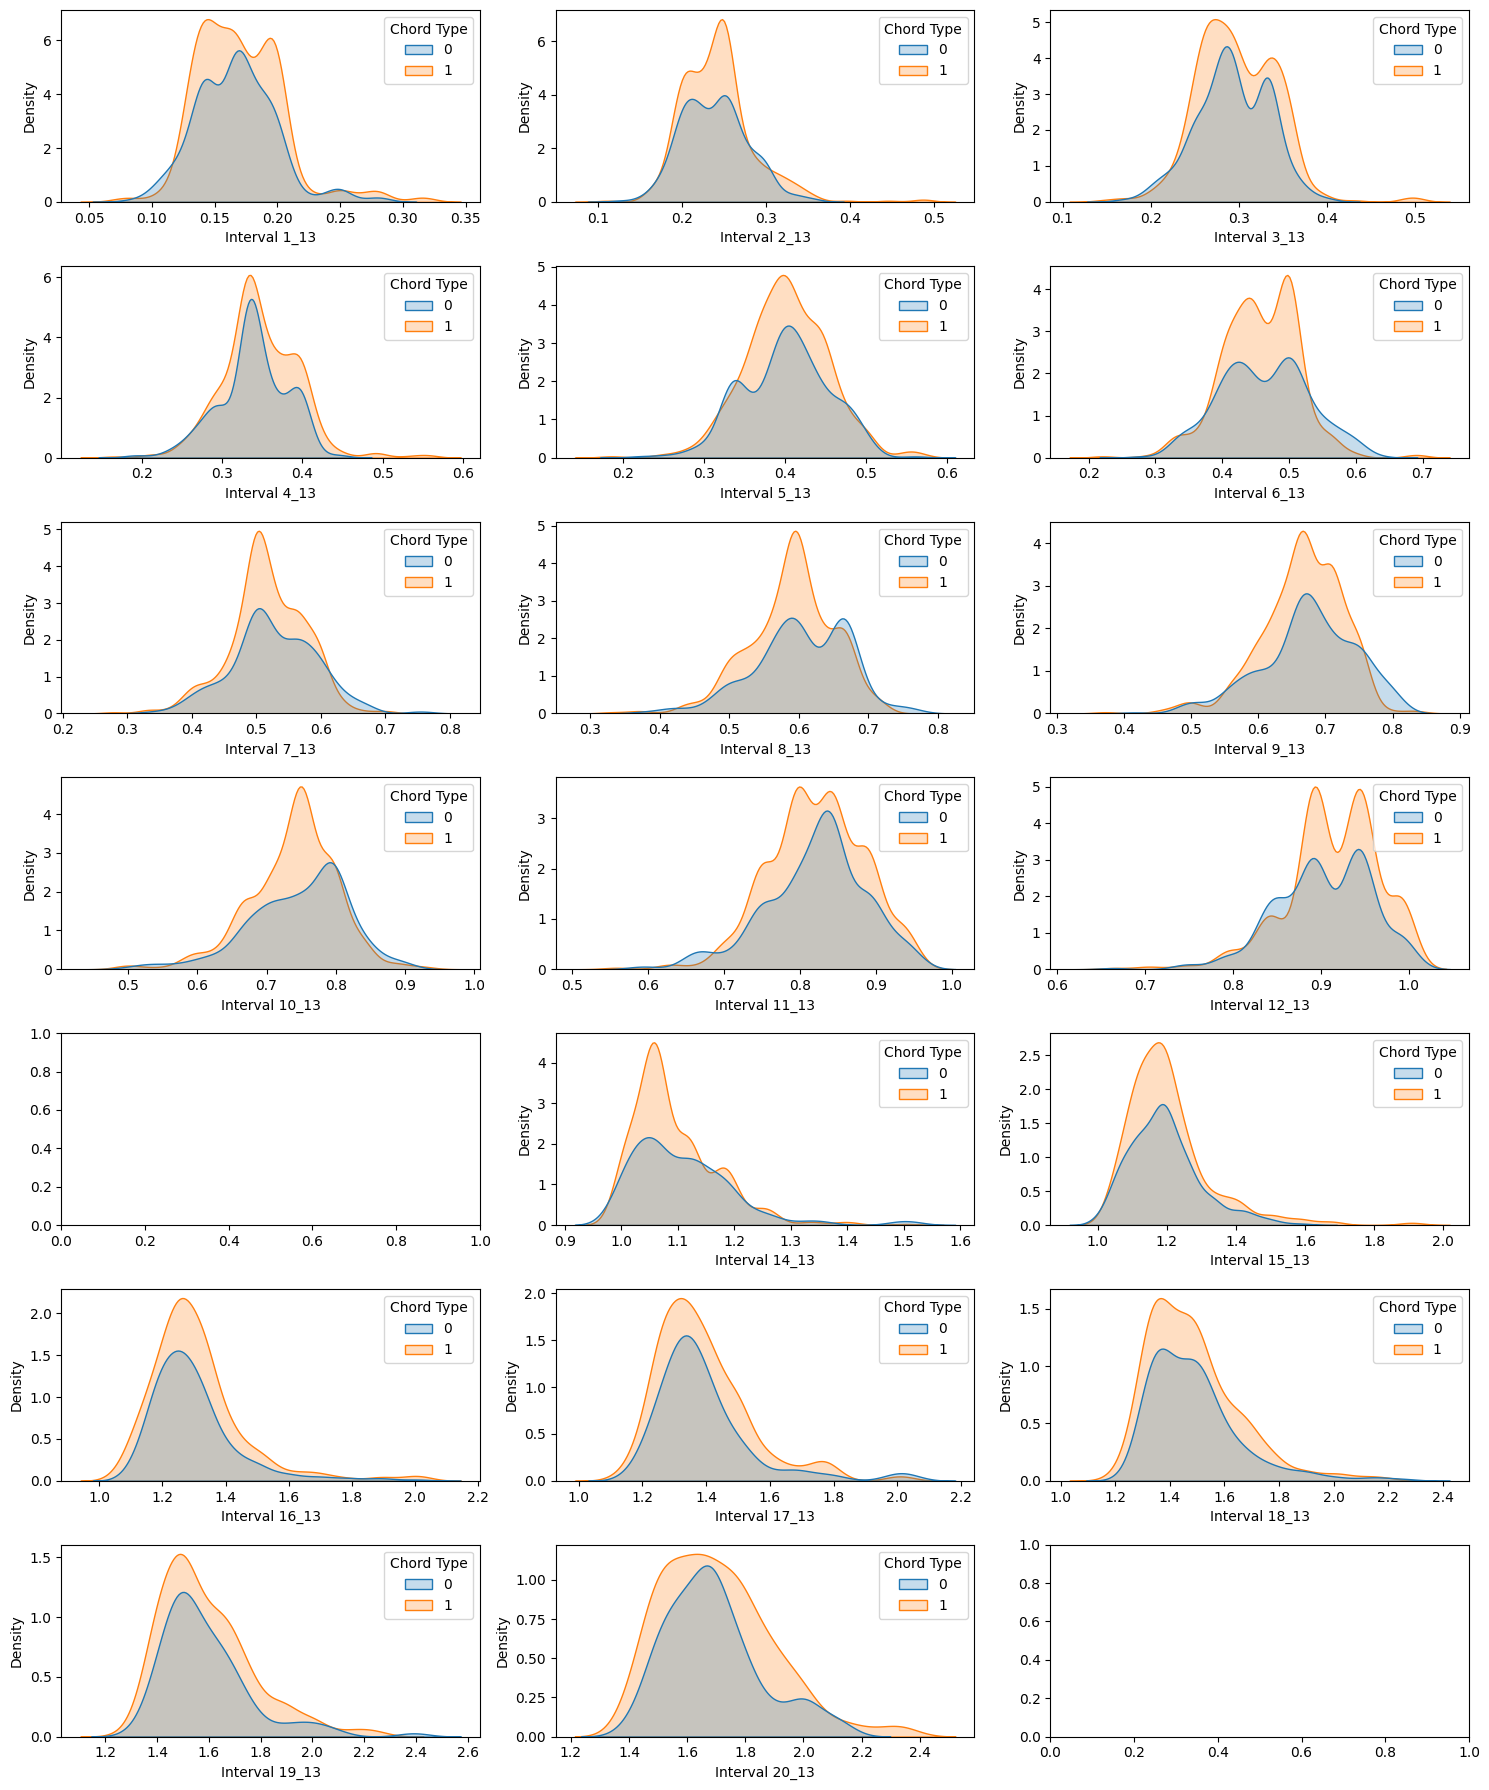

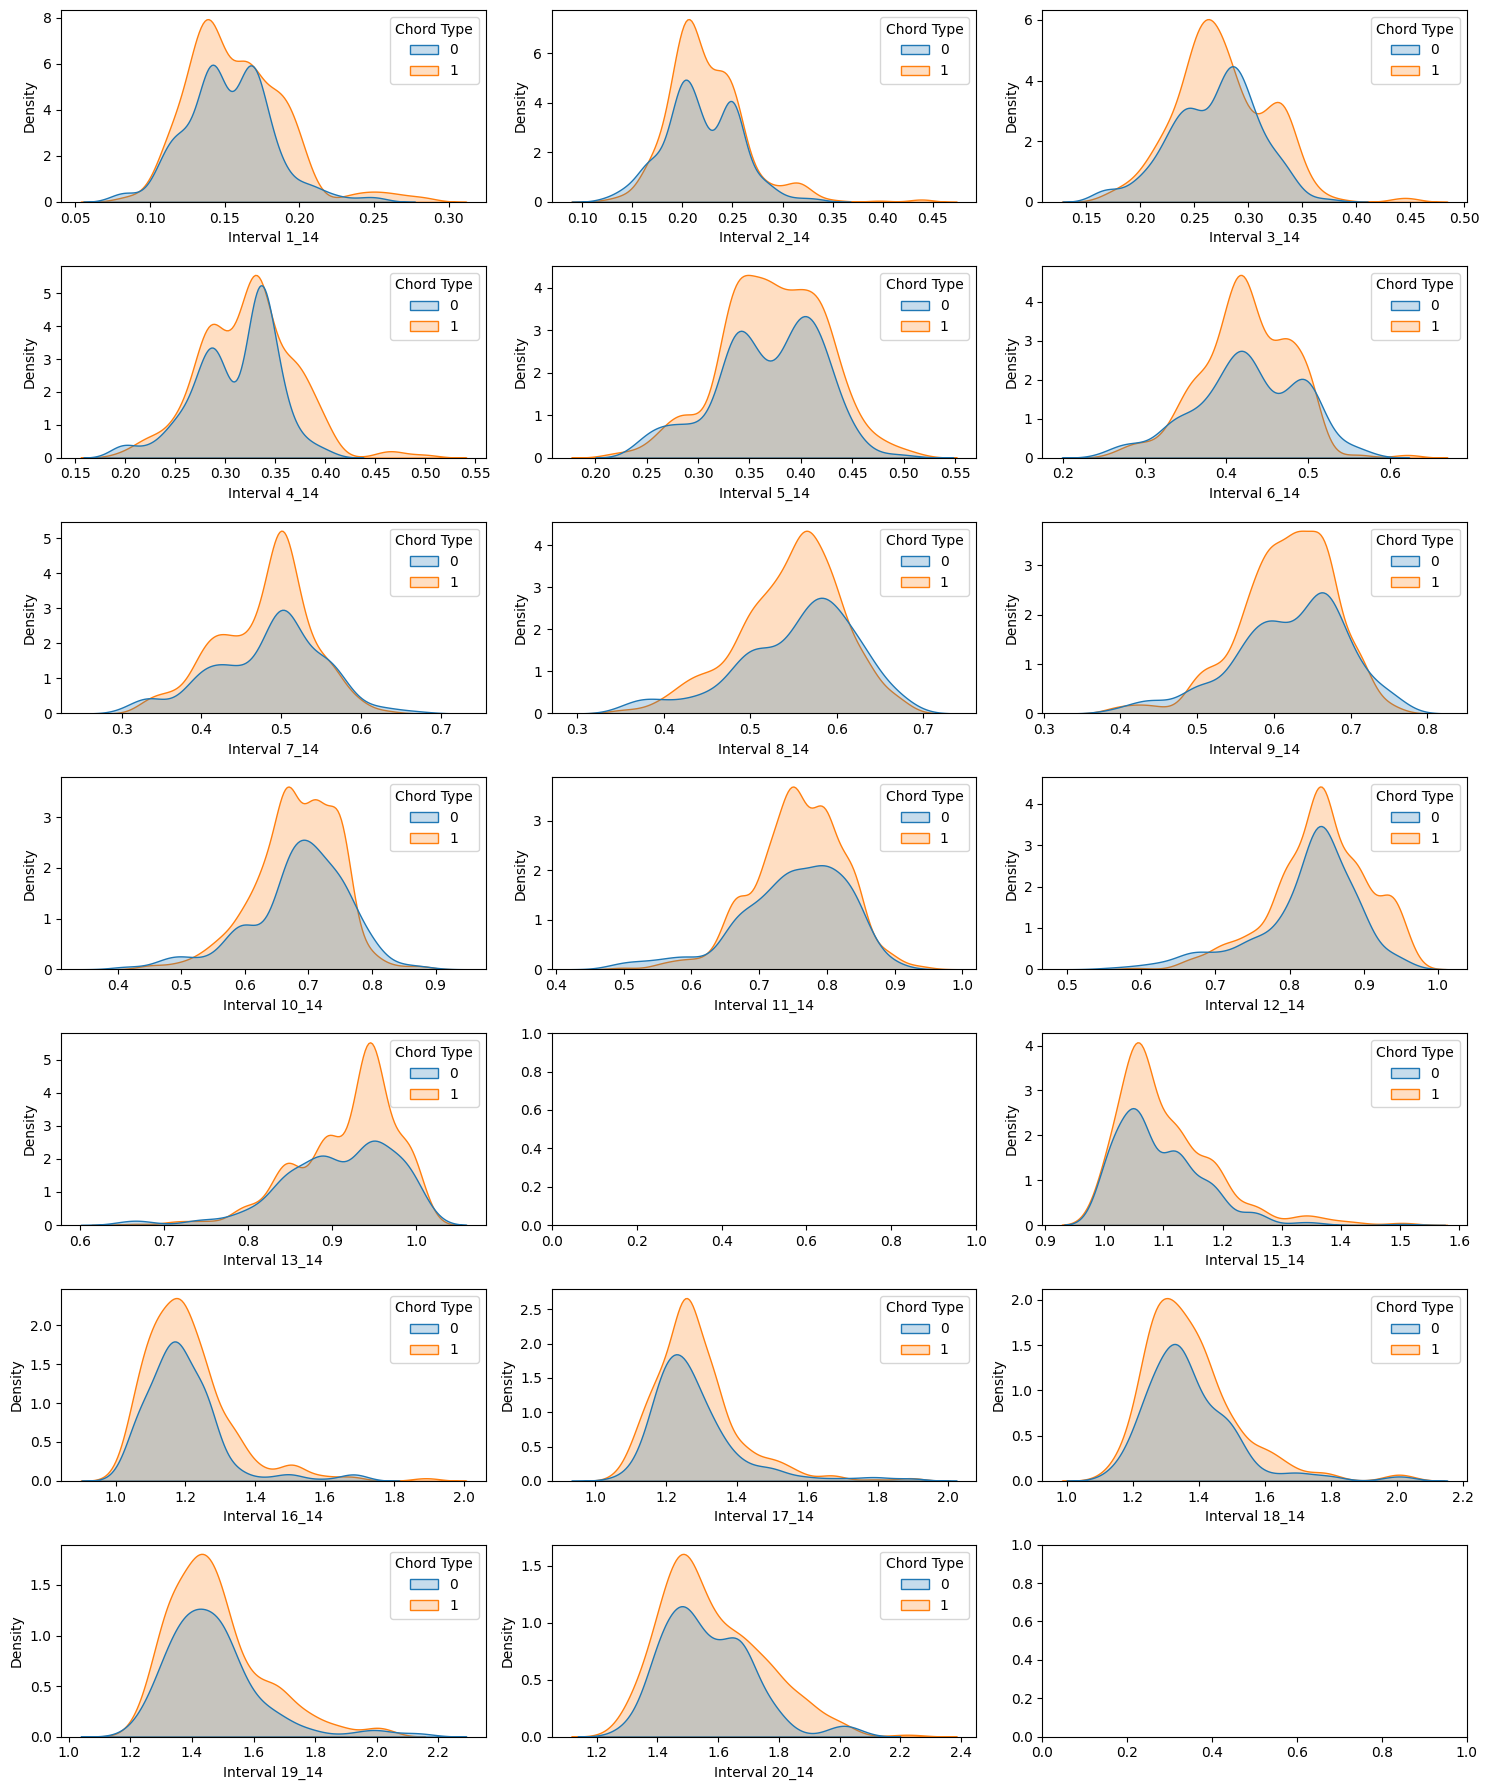

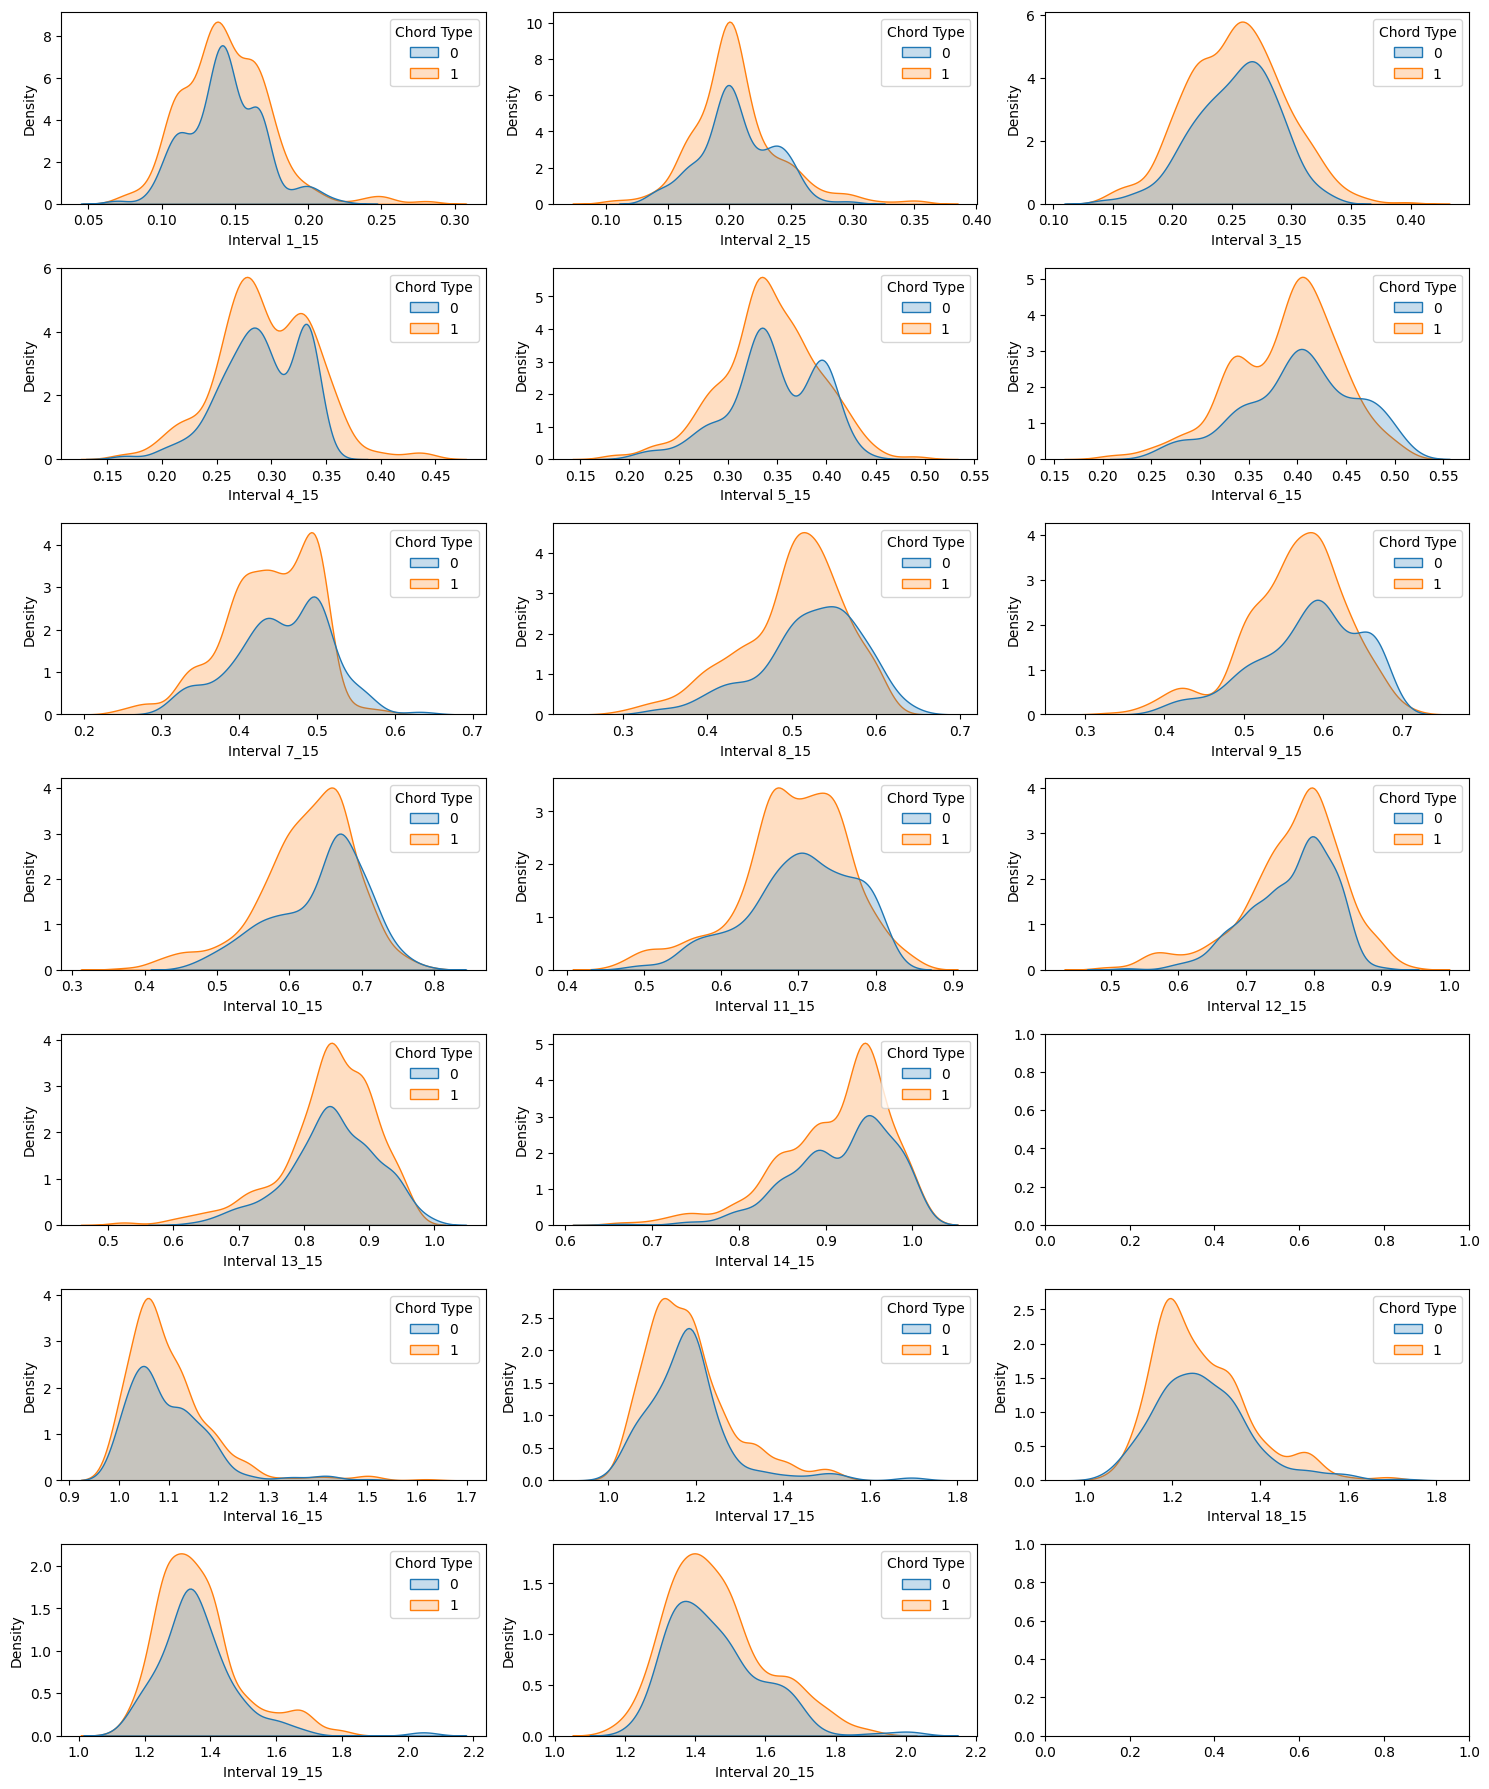

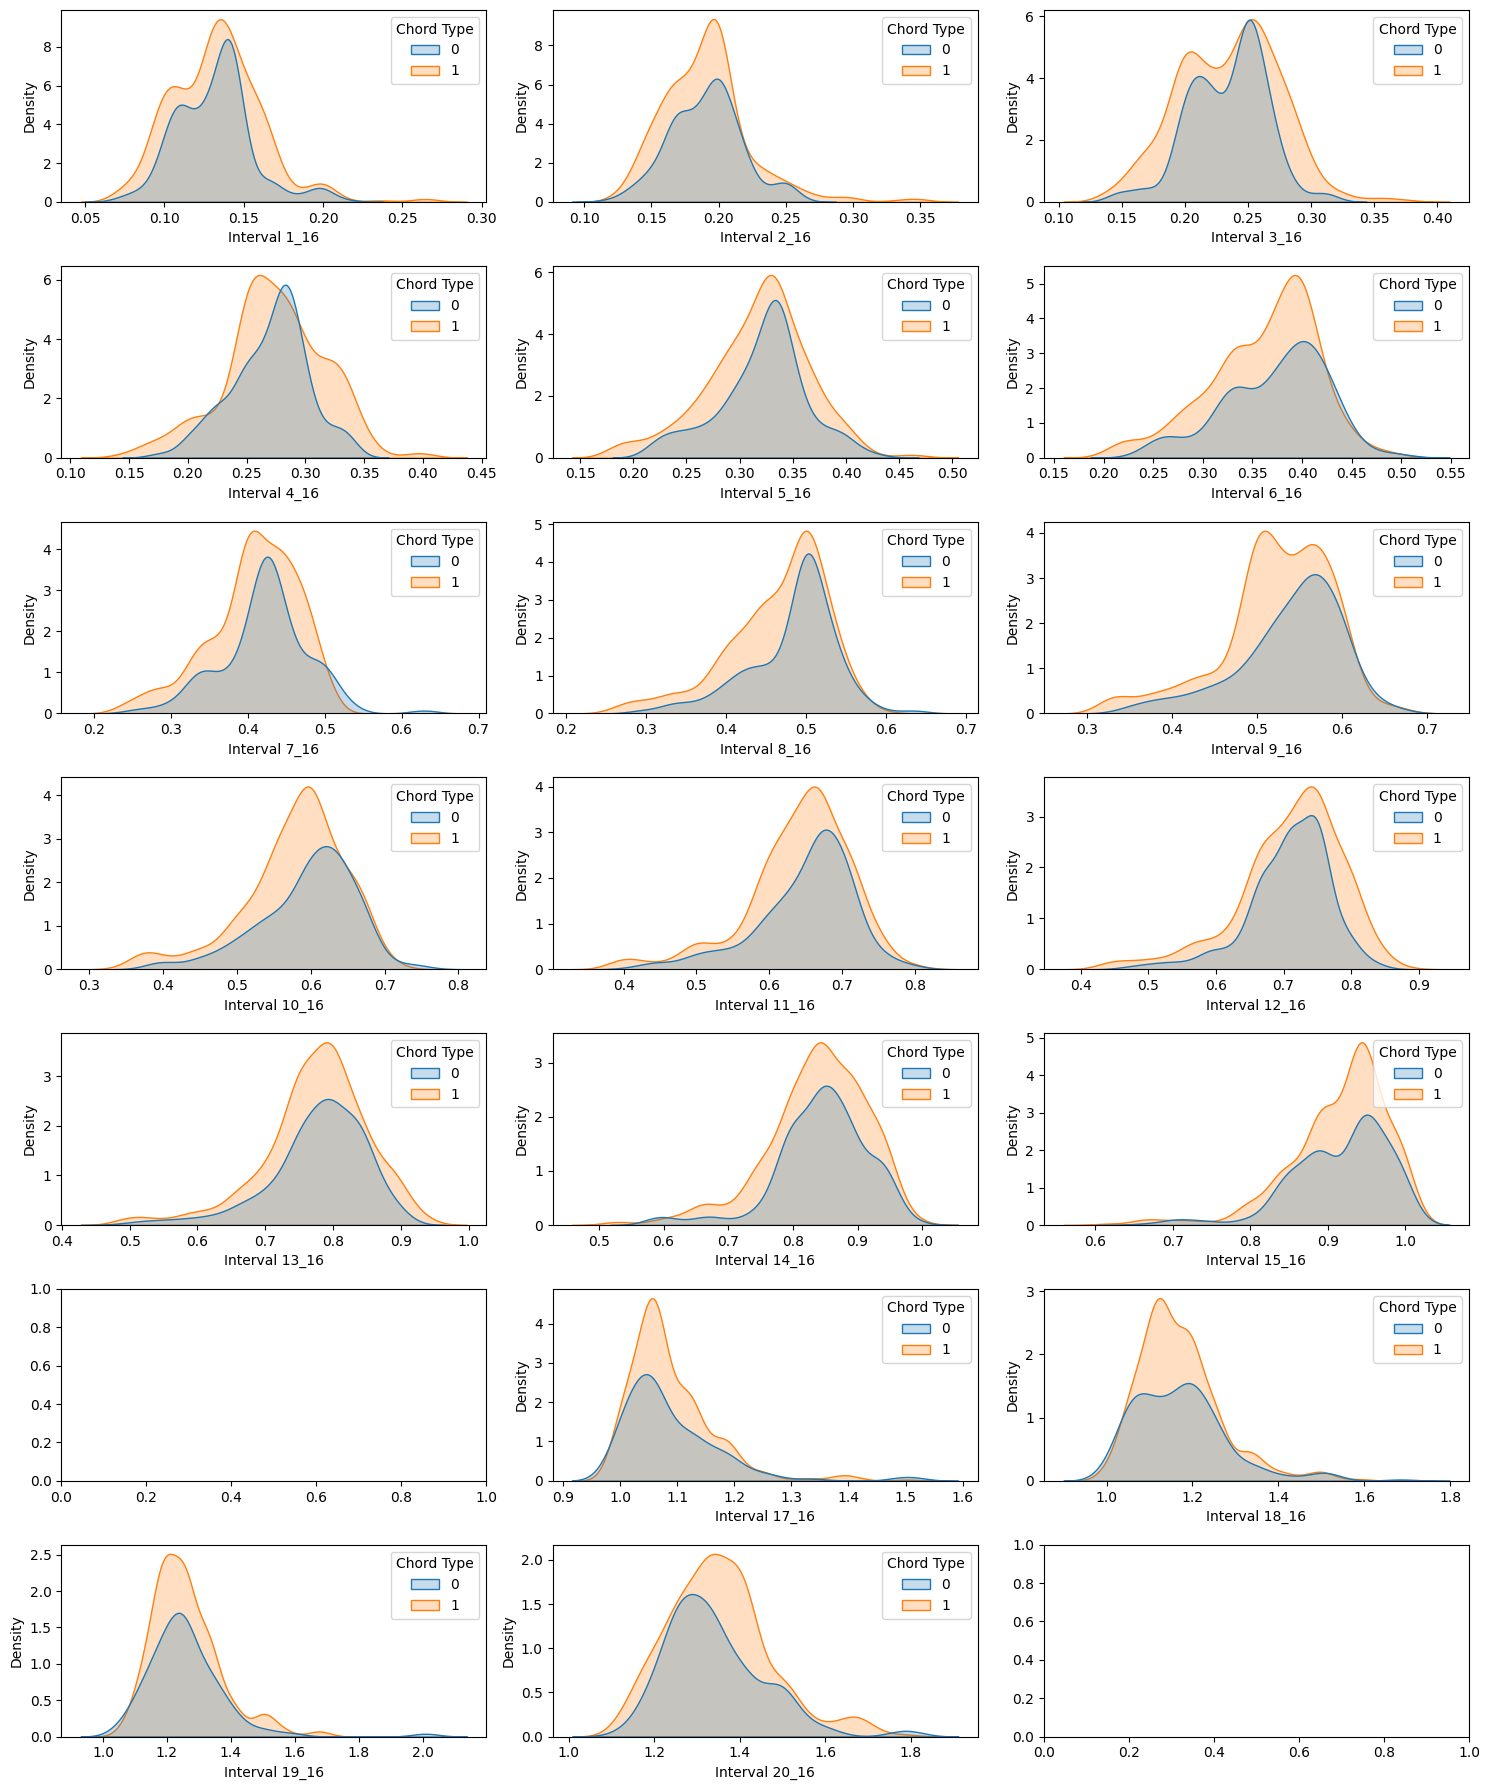

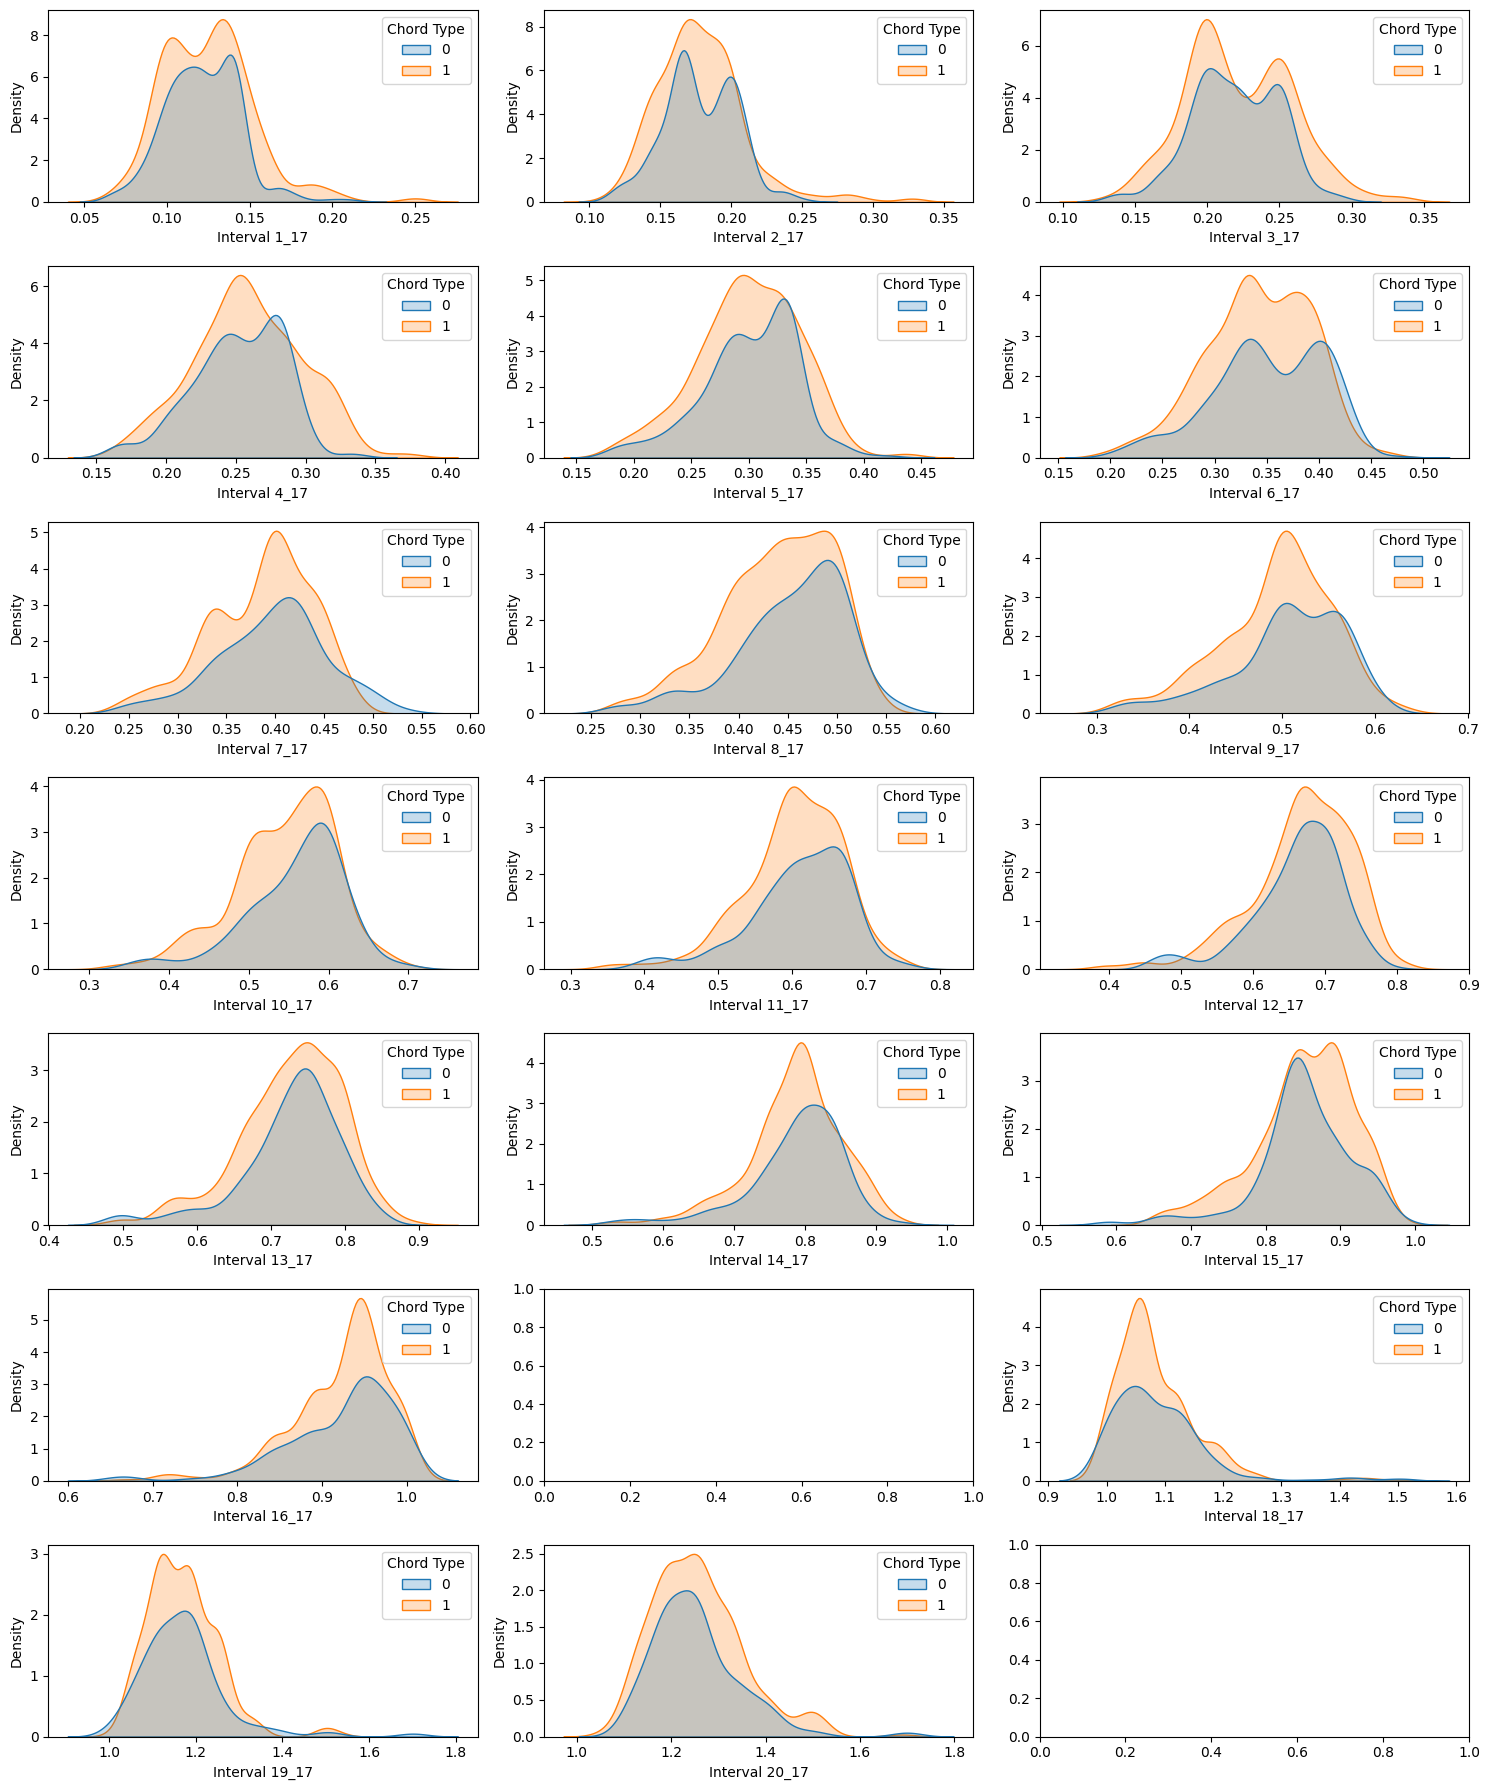

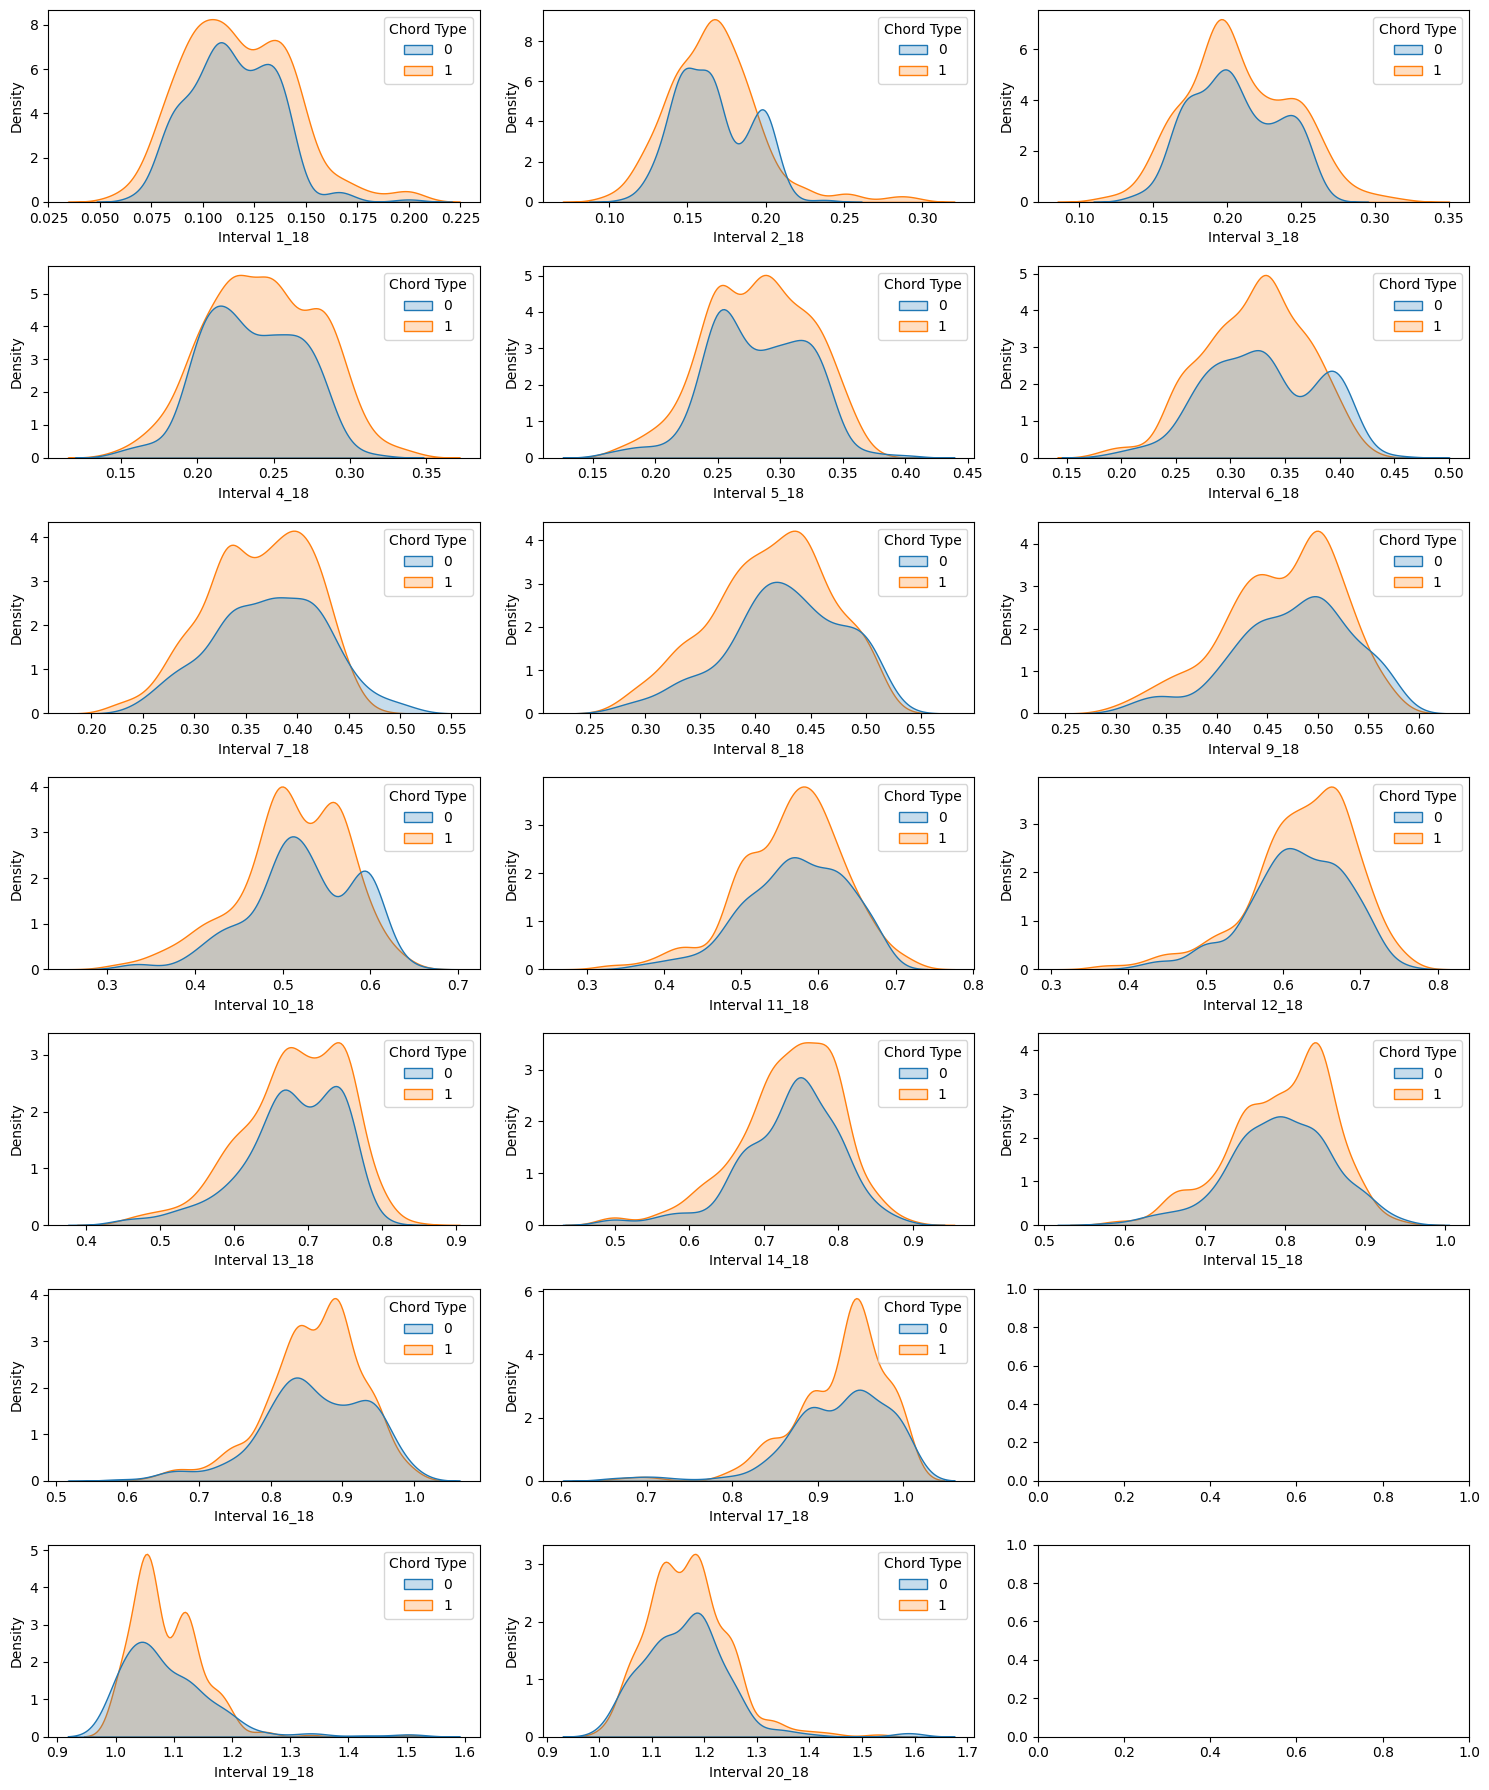

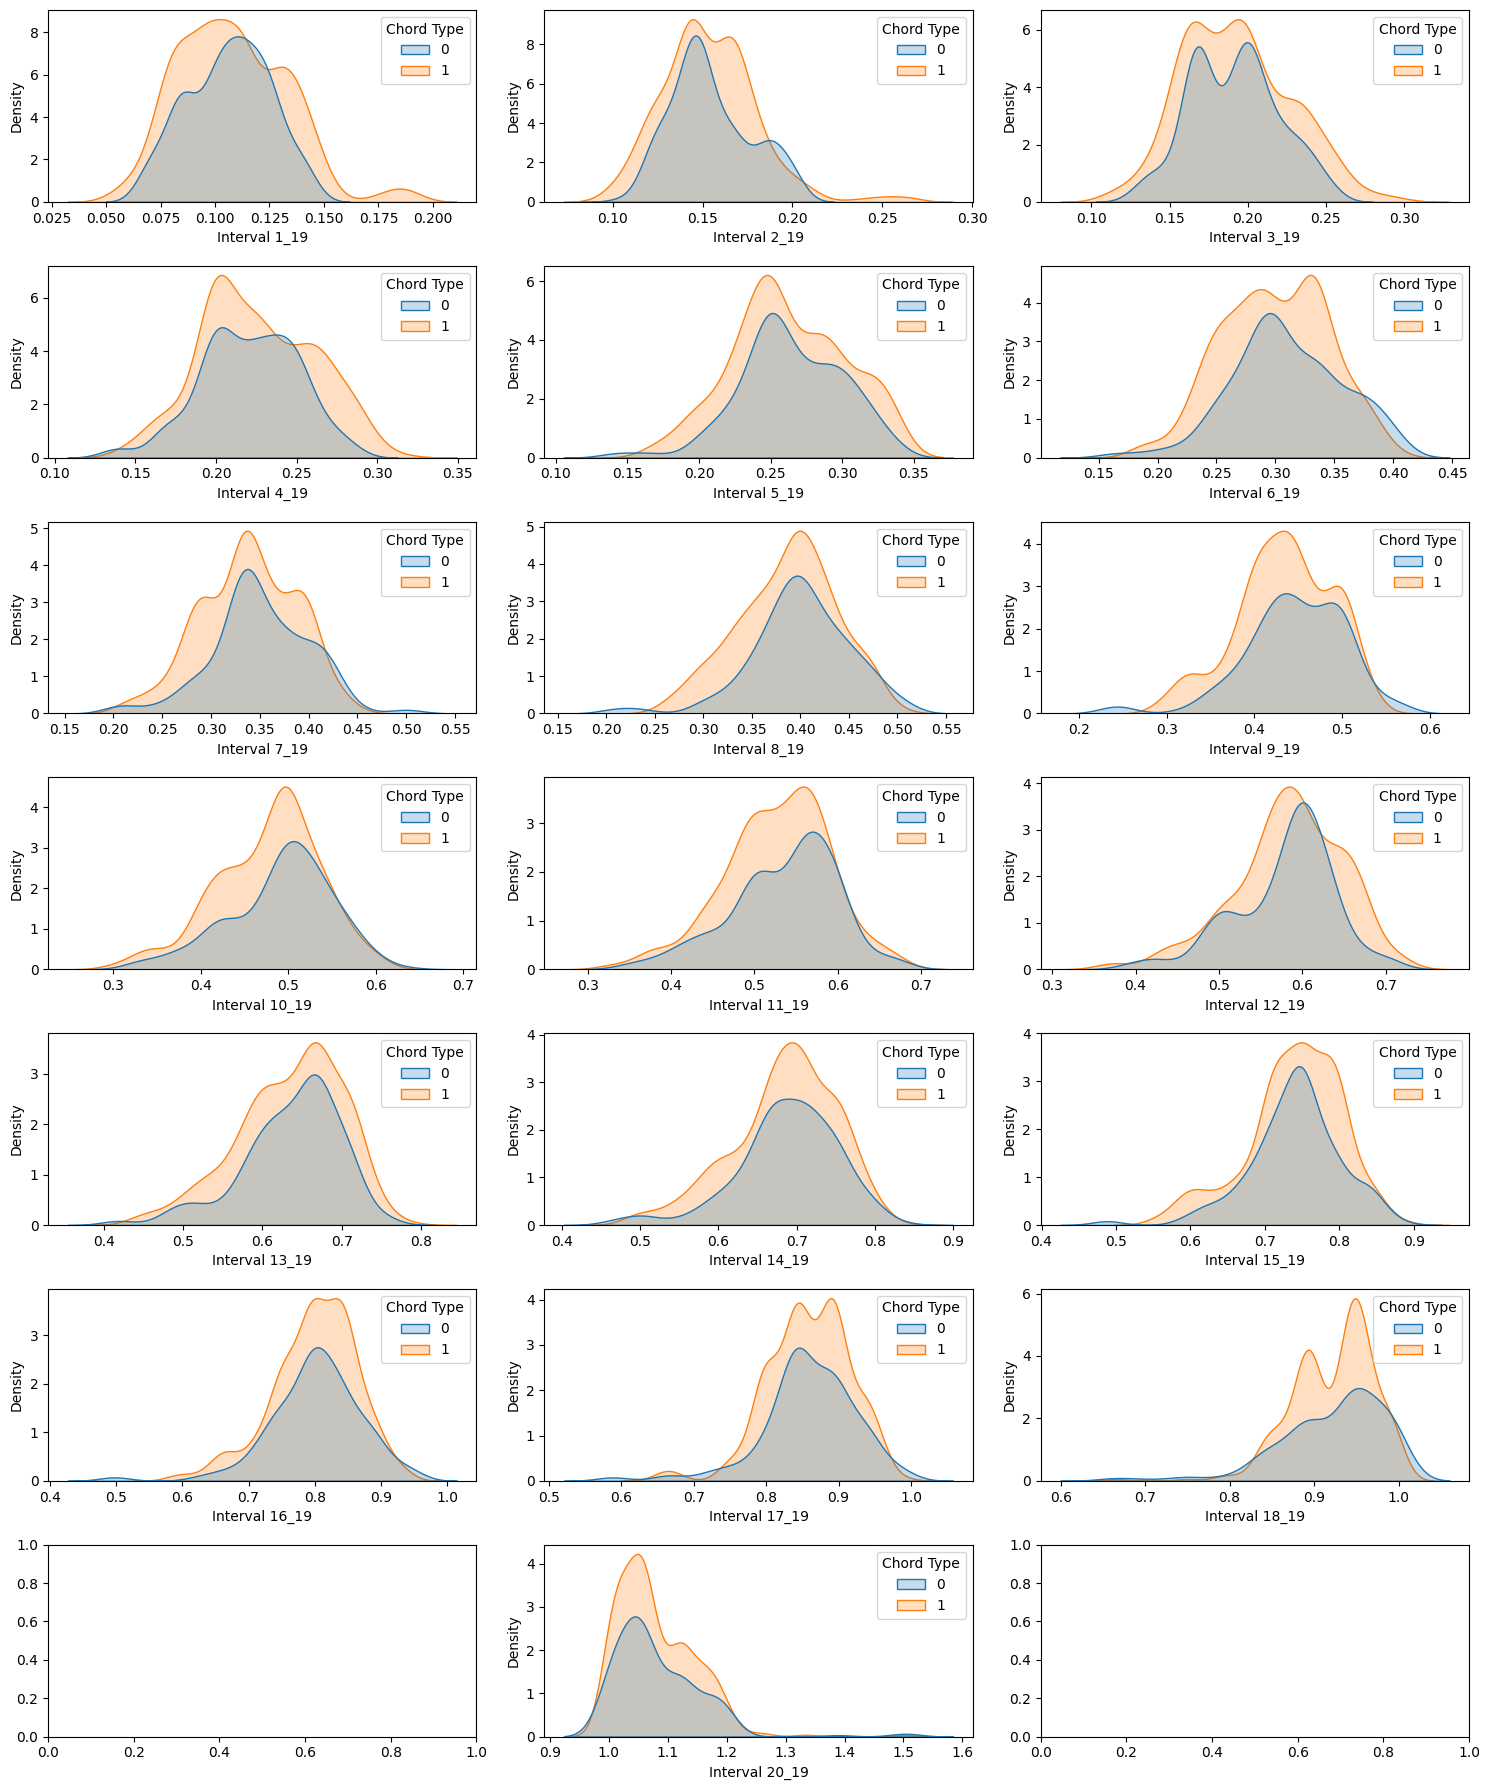

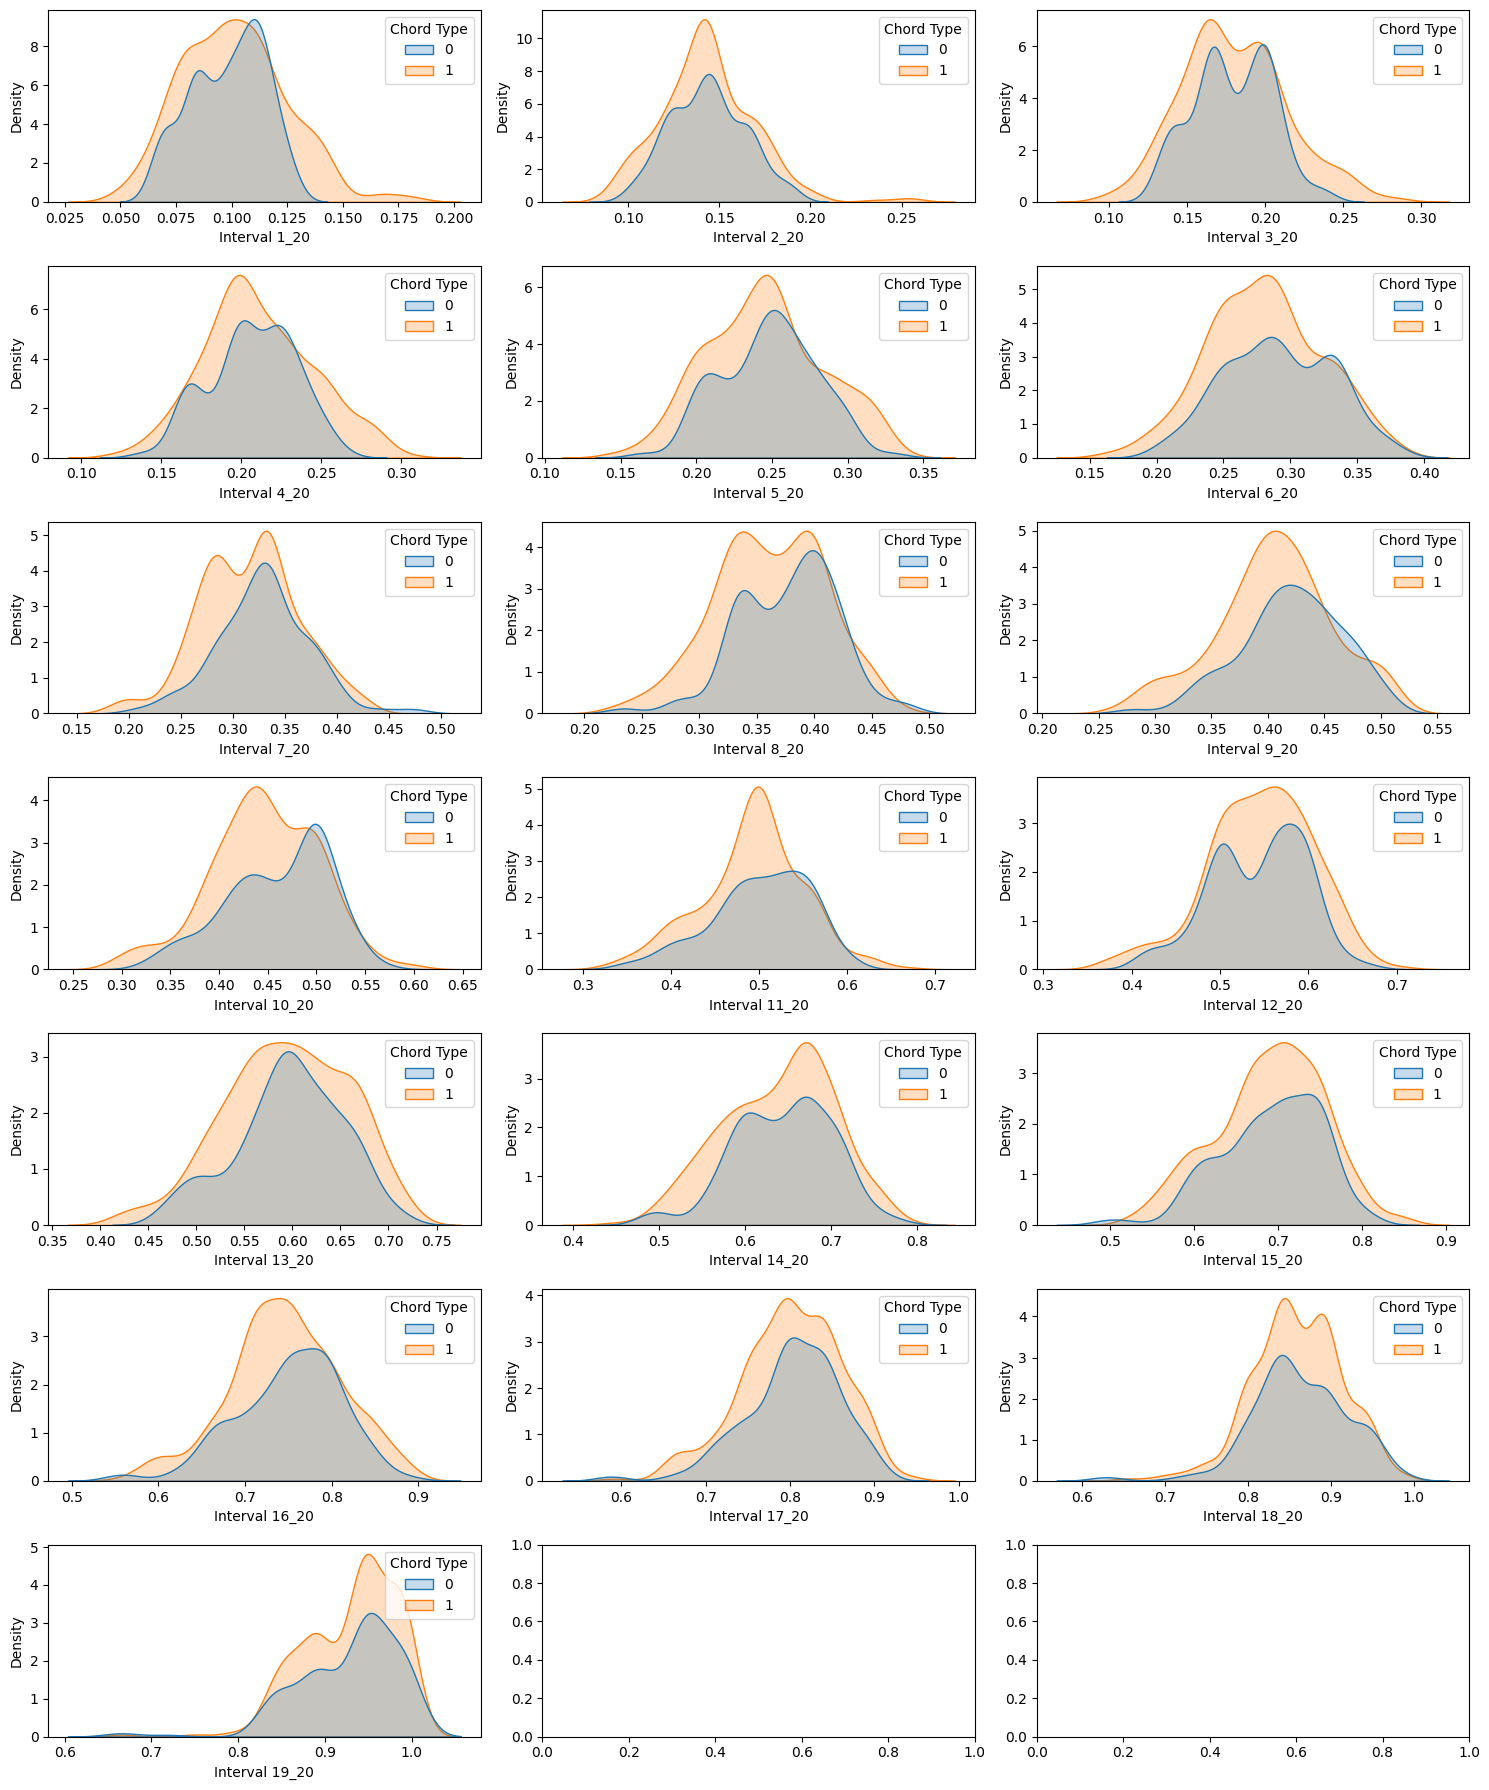

In [272]:
for num in range (1,21):
    # Calculate intervals relative to Harmonic 2 and add them to the DataFrame
    for i in range(1, 21):
        if i == num:
            continue
        interval_col_name = f"Interval {i}_{num}"
        harmonic_col_i_name = f"Harmonic {i}"
        df[interval_col_name] = df[harmonic_col_i_name].div(df[f"Harmonic {num}"], axis=0)

    # Plot KDE plots for all Harmonic 2 intervals using a loop with 2 rows and 3 columns
    fig, axes = plt.subplots(7, 3, figsize=(15, 18))
    axes = axes.flatten()  # Flatten the 2D array of subplots for easier indexing

    for i in range(1, 21):
        if i == num:  # Skip Interval 2_2
            continue
        interval_col_name = f"Interval {i}_{num}"
        sns.kdeplot(ax=axes[i-1], data=df, x=interval_col_name, hue="Chord Type", fill=True)

    fig.tight_layout()
    plt.show()

In [267]:
# Set display option to show all columns
pd.set_option('display.max_columns', None)
print(df.iloc[:3])
pd.reset_option('display.max_columns')

  Chord Type      File Name  Min Harmonic  Max Harmonic  # of Harmonics  \
0      Major  Major_500.wav        116.82       2102.27              27   
1      Major  Major_266.wav        109.78       1949.33              26   
2      Major  Major_272.wav        109.78       1949.33              26   

   Harmonic 1  Harmonic 2  Harmonic 3  Harmonic 4  Harmonic 5  Harmonic 6  \
0      116.82      165.45      221.36      233.64      262.27      330.45   
1      109.78      165.33      220.00      247.11      278.22      330.22   
2      109.78      165.33      220.00      247.11      278.22      330.22   

   Harmonic 7  Harmonic 8  Harmonic 9  Harmonic 10  Harmonic 11  Harmonic 12  \
0      350.45      442.27      467.73       495.45       524.55       663.18   
1      392.00      440.44      494.67       550.67       556.44       660.89   
2      415.56      440.44      494.67       550.67       556.44       660.89   

   Harmonic 13  Harmonic 14  Harmonic 15  Harmonic 16  Harmonic 17  \

- Manually check all Harmonics and Intervals, choose some extremely different ones, i.e., has largest not-overlapped area.

# Model Training and Testing

In [268]:

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

- Try different dataset, test with selected model.

In [269]:
df["Chord Type"] = df["Chord Type"].replace("Major", 1)
df["Chord Type"] = df["Chord Type"].replace("Minor", 0)

columns = ["Interval 2", "Interval 3", "Interval 4", "Interval 5", "Interval 4_3"] #, , "Interval 11", "Interval 18"


"""

columns.extend(["Interval 6_1",  "Interval 3_2", "Interval 2_3", "Interval 4_3", "Interval 3_4", "Interval 7_4",
                 "Interval 1_6", "Interval 5_6", "Interval 4_6", "Interval 7_6", "Interval 4_7", "Interval 6_7"])


columns.extend(["Interval 6_1", "Interval 10_1", "Interval 3_2", "Interval 2_3", "Interval 4_3", "Interval 3_4", "Interval 7_4",
                 "Interval 1_6", "Interval 5_6", "Interval 4_6", "Interval 7_6", "Interval 4_7", "Interval 6_7", "Interval 9_7", 
                 "Interval 11_8", "Interval 8_10", "Interval 7_11", "Interval 8_11", "Interval 14_11", "Interval 13_11", "Interval 2_12", 
                 "Interval 20_12", "Interval 1_13", "Interval 3_14", "Interval 5_15", "Interval 9_16", "Interval 18_16", "Interval 2_17", 
                 "Interval 2_18", "Interval 6_18", "Interval 17_18", "Interval 19_18", "Interval 18_19", "Interval 4_20", "Interval 12_20", 
                 "Interval 7_20", "Interval 11_20"])
                 
# Replace NaN with 0
df.fillna(0, inplace=True)
"""

train_X, test_X, train_y, test_y = train_test_split(df[columns], df["Chord Type"], test_size=0.3, random_state=0)

train_X.head()

Interval 2  Interval 3  Interval 4  Interval 5  Interval 4_3
728    1.335612    1.191840    1.256410    1.339005      1.191840
452    1.310663    1.019035    1.259760    1.188671      1.019035
443    1.411299    1.121930    1.122240    1.127068      1.121930
671    1.194800    1.182601    1.191208    1.064811      1.182601
456    1.193274    1.129090    1.253670    1.169120      1.129090

Confusion Matrix:
[[ 96   7]
 [  8 147]]


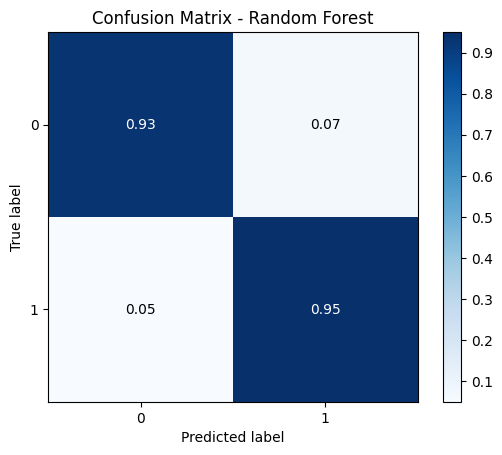

Cross-validated scores: 0.8968457300275482
Accuracy Score: 0.94186
f1_score: 0.95146


In [270]:
import scikitplot as skplt

# Define the calssifier model
model = RandomForestClassifier(random_state=0)

# Train the model
model.fit(train_X, train_y)

# Test with model
pred_y = model.predict(test_X) 

# Perform cross-validated scoring
cv_scores = cross_val_score(model, train_X, train_y, cv=5).mean()

# Compute metrics
cm = confusion_matrix(test_y, pred_y)
accuracy = accuracy_score(test_y, pred_y)
f1 = f1_score(test_y, pred_y)

# Print and plot metrics
print("Confusion Matrix:")
print(cm)
skplt.metrics.plot_confusion_matrix(test_y, pred_y, normalize=True)
plt.title('Confusion Matrix - Random Forest')
plt.show()
print("Cross-validated scores:", cv_scores)
print("Accuracy Score: {:.5f}".format(accuracy))
print("f1_score: {:.5f}".format(f1))

Confusion Matrix:
[[ 96   7]
 [ 13 142]]


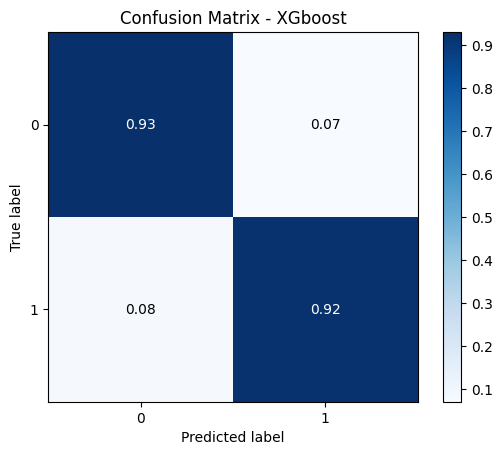

Cross-validated scores: 0.9001928374655647
Accuracy Score: 0.92248
f1_score: 0.93421


In [271]:
import xgboost as xgb

# Define the calssifier model
model = xgb.XGBClassifier()

# Train the model
model.fit(train_X, train_y)

# Test with model
pred_y = model.predict(test_X)

# Perform cross-validated scoring
cv_scores = cross_val_score(model, train_X, train_y, cv=5).mean()

# Compute metrics
cm = confusion_matrix(test_y, pred_y)
accuracy = accuracy_score(test_y, pred_y)
f1 = f1_score(test_y, pred_y)

# Print and plot metrics
print("Confusion Matrix:")
print(cm)
skplt.metrics.plot_confusion_matrix(test_y, pred_y, normalize=True)
plt.title('Confusion Matrix - XGboost')
plt.show()
print("Cross-validated scores:", cv_scores)
print("Accuracy Score: {:.5f}".format(accuracy))
print("f1_score: {:.5f}".format(f1))


- With ["Interval 2", "Interval 3", "Interval 4", "Interval 5", "Interval 4_3"], the accuracy with random forest model improve from 0.91 to 0.94, and the accuracy with xgboost model is 0.92.